In [34]:
import pandas as pd
import numpy as np
import re
from itertools import permutations
import csv

from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
 
import difflib
from math import isnan
import math as m

from collections import Counter

import panel as pn
import sys
import altair as alt

In [35]:
import dataframe_image as dfi

In [36]:
                            #--------LEITURA--------
df1 = pd.read_csv('dados.csv')
df1 = df1.rename(columns={"Timestamp_before.1": "time_request", "Timestamp_after.1": "time_response", "Request": "user_request", "Response": "system_response"})
df1 = df1.drop(['Timestamp_before', 'Timestamp_after', 'Link'], axis=1)

#time_request: hora de execução pelo usuário
#time_respose: hora de resposta do sistema
#user_request: informações que o usuário envia para o VISIR (características da experimentação)
#system_response: resposta do sistema à confifuração gerada pelo usuário

In [37]:
                            #--------PRE-PROCESSAMENTO--------

#extrair apenas acessos com realização de manipulação
df2 = df1.loc[df1['user_request'].str.contains(r'^(?=.*protocol)')]
df2.reset_index(drop=True, inplace=True)

act_df = df2[:]
act_df = act_df.drop(['user_request', 'system_response', 'time_response'], axis=1)

#----ID-------
sessionkey_list= df2['user_request'].str.extract(r'(?s:.*sessionkey)([a-zA-Z0-9=!><#$&()\\-`.+,/\" :]+)')
sessionkey_list.fillna(method='bfill', inplace=True)
sessionkey_list = sessionkey_list[0].str.slice(start=6, stop=35).to_list()
act_df.insert(0, "sessionkey", sessionkey_list, True)
act_df['sessionkey'] = act_df['sessionkey'].replace('"', '', regex=True)

#-----DATA-------
act_df['time_request'] = pd.to_datetime(act_df['time_request'])
#act_df['date'] = act_df['time_request'].dt.date
#act_df['time'] = act_df['time_request'].dt.time

#-----BREADBOARD-----
act_df['breadboard'] = df2['user_request'].str.extract(r'(?s:.+<circuitlist>)([a-zA-Z0-9=!#$&()\\-`.+,/\" ]+)(?:./circuitlist>)').fillna('')
act_df['breadboard'] = act_df['breadboard'].replace(r'(\d+(?:\.\d+)?[kKMGTPEZY]?)_X\b', r'\1', regex=True)

#ADICIONAR SEPARAÇÃO
w_x_pattern = r'(W_X\s+\S+\s+\S+)'
r_x_pattern = r'(R_X\s+\S+\s+\S+\s+\S+)'
c_x_pattern = r'(C_X\s+\S+\s+\S+\s+\S+)'
dmm_pattern = r'(DMM_[12]\s+\S+\s+\S+)'
vdc_pattern = r'(VDC\+6V_1\s+\S+)'
probe_pattern = r'(IPROBE_[12]\s+\S+\s+\S+)'

def find_matches(row):
    w_x_matches = re.findall(w_x_pattern, row)
    r_x_matches = re.findall(r_x_pattern, row)
    c_x_matches = re.findall(c_x_pattern, row)
    dmm_matches = re.findall(dmm_pattern, row)
    vdc_matches = re.findall(vdc_pattern, row)
    probe_matches = re.findall(probe_pattern, row)
    
    formatted_w_x = ', '.join(w_x_matches)
    formatted_r_x = ', '.join(r_x_matches)
    formatted_c_x = ', '.join(c_x_matches)
    formatted_probe = ', '.join(probe_matches)
    formatted_dmm = ', '.join(dmm_matches)
    formatted_vdc = ', '.join(vdc_matches)
    
    formatted_parts = [formatted_w_x, formatted_r_x, formatted_c_x, formatted_probe, formatted_dmm, formatted_vdc]

    formatted_parts = [part for part in formatted_parts if part]

    return ', '.join(formatted_parts)

act_df['breadboard'] = act_df['breadboard'].apply(find_matches)

#LIMPEZA
act_df['breadboard'] = act_df['breadboard'].replace(r'470', r'470k', regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r'([A]\d{1})([A-Z]_X)\b', r'\1, \2', regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r'([A]\d{2})([A-Z]_X)\b', r'\1, \2', regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r'(\d+k)(\w+)',  r'\1, \2', regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r'(DMM_1_[12])([A-Z])',  r'\1, \2', regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r'(IPROBE_1_[12])([A-Z])',  r'\1, \2', regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r'(25V_1_[12])([A-Z]_X)',  r'\1, \2', regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r'(0)([A-Z])',  r'\1, \2', regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r'(S)([A-Z])',  r'\1, \2', regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r'(100)([A-Z])',  r'\1k, \2', regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r'(100)',  r'\1k', regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r'([F]\d{1})([A-Z]_X)\b', r'\1, \2', regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r'([F]\d{2})([A-Z]_X)\b', r'\1, \2', regex=True)

#substituir A para V
act_df['breadboard'] = act_df['breadboard'].replace(r'DMM_AHI',  r'DMM_VHI', regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r'DMM_ALO',  r'DMM_VLO', regex=True)

#substituir identificação do aterramento de 0 para GND
act_df['breadboard'] = act_df['breadboard'].replace(r"([^A-Z0-9])0([^A-Z0-9])",  r"\1GND\2 ", regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r"([^A-Z0-9])0$",  r"\1GND", regex=True)

#alterar registro de posição para um sistema único Axx
act_df['breadboard'] = act_df['breadboard'].replace(r"A([0-9][^0-9])",  r"A0\1", regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r"F1([0-9])",  r"A6\1", regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r"F2([0-9])",  r"A7\1", regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r"F3([0-9])",  r"A8\1", regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r"F([0-9])",  r"A5\1", regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r"([^A-Z0-9_])X([^A-Z0-9_])", r"\1 A90 \2", regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r"([^A-Z0-9_])X$",  r"\1A90", regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r"([^A-Z0-9_])Y([^A-Z0-9_])", r"\1 A91 \2", regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r"([^A-Z0-9_])Y$",  r"\1A91", regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r"([^A-Z0-9_])S([^A-Z0-9_])", r"\1 A92 \2", regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r"([^A-Z0-9_])S$",  r"\1A92", regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r"([^A-Z0-9_])T([^A-Z0-9_])", r"\1 A93 \2", regex=True)
act_df['breadboard'] = act_df['breadboard'].replace(r"([^A-Z0-9_])T$",  r"\1 A93", regex=True)

#-----FONTE-----

act_df['DC'] = df2['system_response'].str.extract(r'(?s:.+<dc_outputs>)([a-zA-Z0-9=!><#$&()\\-`.+,_/\" V-]+)(?:.</dc_outputs>)').fillna(0)

act_df['DC6+'] = act_df['DC'].str.extract(r'<dc_output channel="6V\+">(.*?)</dc_output>').fillna(0)
act_df['DC6+_volt'] = act_df['DC6+'].str.extract(r' value="(.*?)/> <dc_current').fillna(0)
act_df['DC6+_cur'] = act_df['DC6+'].str.extract(r'<dc_current value=(.*?)/> <dc_voltage_actual').fillna(0)
act_df['DC6+_volt'] = act_df['DC6+_volt'].replace('"', '', regex=True)
act_df['DC6+_cur'] = act_df['DC6+_cur'].replace('"', '', regex=True)

act_df['DC25+'] = act_df['DC'].str.extract(r'<dc_output channel="25V\+">(.*?)</dc_output>').fillna(0)
act_df['DC25+_volt'] = act_df['DC25+'].str.extract(r' value="(.*?)/> <dc_current').fillna(0)
act_df['DC25+_cur'] = act_df['DC25+'].str.extract(r'<dc_current value=(.*?)/> <dc_voltage_actual').fillna(0)
act_df['DC25+_volt'] = act_df['DC25+_volt'].replace('"', '', regex=True)
act_df['DC25+_cur'] = act_df['DC25+_cur'].replace('"', '', regex=True)

act_df['DC25-'] = act_df['DC'].str.extract(r'<dc_output channel="25V\-">(.*?)</dc_output>').fillna(0)
act_df['DC25-_volt'] = act_df['DC25-'].str.extract(r' value="(.*?)/> <dc_current').fillna(0)
act_df['DC25-_cur'] = act_df['DC25-'].str.extract(r'<dc_current value=(.*?)/> <dc_voltage_actual').fillna(0)
act_df['DC25-_volt'] = act_df['DC25-_volt'].replace('"', '', regex=True)
act_df['DC25-_cur'] = act_df['DC25-_cur'].replace('"', '', regex=True)

act_df = act_df.drop(['DC'], axis=1)
act_df = act_df.drop(['DC6+'], axis=1)
act_df = act_df.drop(['DC25+'], axis=1)
act_df = act_df.drop(['DC25-'], axis=1)

#-----MULTIMETRO-----
act_df['DMM_conf'] = df2['user_request'].str.extract(r'(?s:.+<dmm_function value=")([a-zA-Z0-9=!><#$&()\\-`.+,/\" ]+)(?:."></dmm_function)').fillna(0)
act_df['DMM_conf'] = act_df['DMM_conf'].replace('curren', 'current', regex=True)
act_df['DMM_conf']

act_df['DMM_value'] = df2['system_response'].str.extract(r'(?s:.+<dmm_result value)([a-zA-Z0-9=!><#$&()\\-`.+,/\" ]+)(?:.</multimeter>)').fillna(0)
#limpeza string valor multimetro
act_df['DMM_value'] = act_df['DMM_value'].replace('"', '', regex=True)
act_df['DMM_value'] = act_df['DMM_value'].replace('nan', np.nan, regex=True)
act_df['DMM_value'] = act_df['DMM_value'].fillna(0)
act_df['DMM_value'] = act_df['DMM_value'].replace('=', '', regex=True)
act_df['DMM_value'] = act_df['DMM_value'].replace('/', '', regex=True)
act_df['DMM_value'] = act_df['DMM_value'].replace('>', '', regex=True)
act_df['DMM_value'] = act_df['DMM_value'].replace('#QNAN', '00000', regex=True)
#act_df['DMM_value'] = act_df['DMM_value'].replace('1.#QNAN0e+000', '01', regex=True)

#-----FORMATAÇÃO VALOR 2 CASAS DECIMAIS-----
def valor_2casas(act_df, column_name):
    act_df[column_name] = act_df[column_name].apply(lambda x: "{:.2f}".format(float(x)) if x != '0.000000e+0' else 0.00)
    act_df[column_name] = act_df[column_name].astype(float)

valor_2casas(act_df, 'DMM_value')
valor_2casas(act_df, 'DC6+_cur')
valor_2casas(act_df, 'DC6+_volt')
valor_2casas(act_df, 'DC25+_cur')
valor_2casas(act_df, 'DC25+_volt')
valor_2casas(act_df, 'DC25-_cur')
valor_2casas(act_df, 'DC25-_volt')

act_df = act_df.fillna(0)

#-----REMOÇÃO DUPLICADOS-----
act_df = act_df.drop_duplicates()
act_df.reset_index(drop=True, inplace=True)

act_df['breadboard'].replace('', np.nan, inplace=True)
act_df = act_df.dropna(subset=['breadboard'])
act_df.reset_index(drop=True, inplace=True)
df3 = act_df[['sessionkey', 'time_request','breadboard']].copy()
act_df = act_df.drop(['breadboard'], axis=1)

#act_df.head(5)

In [38]:
#-------Normalizaçao

#https://github.com/vanessaserrano/visirTR/blob/master/dashboard/functions_VISIRDB.R

#Split the representation for each component
split_data = []
for item in df3['breadboard']:
    components = item.split(', ')
    split_components = []
    for component in components:
        split_components.append(component.split(' '))
    split_data.append(split_components)

# Lexicographically reorder the nodes and components
ordered_data = []
for components in split_data:
    ordered_components = []
    for component in components:
        ordered_component = sorted(component[1:], key=lambda x: x.split('_')[-1])
        ordered_components.append([component[0]] + ordered_component)
    ordered_components.sort(key=lambda x: x[0])
    ordered_data.append(ordered_components)

#df2['breadboard_norm'] = ordered_data

#remover duplicados
def remove_duplicates(lst):
    seen = set()
    new_lst = []
    for item in lst:
        if tuple(item) not in seen and item != ['']:
            seen.add(tuple(item))
            new_lst.append(item)
    return new_lst

def normalizar_circuito(data):
    normr = []
    cont_norm = 0

    for circuito_list in data:
        normr_inner = []
        for circuito in circuito_list:
            x = " ".join(circuito)

            if x is None or x == "":
                continue

            circuito = x

            componentes = circuito.split("/")

            for i in range(len(componentes)):
                conectores = componentes[i].split()
                if len(conectores) >= 3:
                    if conectores[1] > conectores[2]:
                        conectores[1], conectores[2] = conectores[2], conectores[1]

                    if conectores[0] == "W_X" and conectores[1][0] == "A":
                        componentes = [re.sub(re.escape(conectores[1]), conectores[2], comp) if comp != componentes[i] else "" for comp in componentes]
                        cont_norm += 1
                    else:
                        componentes[i] = " ".join(conectores)
            componentes = sorted(componentes, key=lambda comp: re.sub(r"A[0-9][0-9]", "Axx", comp))
            circuito = "/".join(componentes)
            circuito = re.sub(r"^/*", "", circuito)

            componentes = circuito.split("/")
            for i in range(len(componentes)):
                conectores = componentes[i].split()
                if len(conectores) >= 3:
                    if conectores[1] > conectores[2]:
                        conectores[1], conectores[2] = conectores[2], conectores[1]
                    componentes[i] = " ".join(conectores)
            componentes = sorted(componentes, key=lambda comp: re.sub(r"A[0-9][0-9]", "Axx", comp))
            circuito = "/".join(componentes)

            nodos = re.findall(r"A[0-9][0-9]", circuito)
            nodos = list(set(nodos)) if nodos else []
            if 0 < len(nodos) < 9:
                nodos_unif = [f"P{str(i).zfill(2)}" for i in range(1, 10)] + [f"P{i}" for i in range(10, 100)]
                nodos_unif = nodos_unif[:len(nodos)]
                mat_nodos_unif = list(permutations(nodos_unif))
                r_circuitos = [re.sub("|".join(nodos), lambda m: mat_nodos_unif[i][nodos.index(m.group())], circuito) for i in range(len(mat_nodos_unif))]
                circuito = min(r_circuitos)

            normr_inner.append(circuito)
        normr_inner = remove_duplicates(normr_inner)
        normr.append(normr_inner)

    # Remove strings vazias
    normr = [[c for c in inner if c] for inner in normr]

    return normr

df3['breadboard_norm'] = normalizar_circuito(ordered_data)
df3['breadboard_norm'] = [', '.join(map(str, l)) for l in df3['breadboard_norm']]

In [39]:
#--------Simplificação

def simplificar_circuito(circuit):
    if circuit is None:
        return None
    if circuit == "":
        return ""

    circuit_prin = None

    components = circuit.split(",")
    connectors = [(component.split(" ")) for component in components]
    df = pd.DataFrame(components)

    #o circuito deve conter os cabos do multimetro
    valid = ("DMM_VLO" in circuit and "DMM_VHI" in circuit) or \
            ("DMM_ALO" in circuit and "DMM_AHI" in circuit) or \
            ("DMM_1_1" in circuit and "DMM_1_2" in circuit) or \
            ("IPROBE_1_1" in circuit and "IPROBE_1_2" in circuit) or \
            ("DMM_2_1" in circuit and "DMM_2_2" in circuit) or \
            ("IPROBE_2_1" in circuit and "IPROBE_2_2" in circuit)

    if not valid:
        return ""

    nodesf1 = None

    #nodo inicial do fragmento principal
    if "DMM_VLO" in circuit and "DMM_VHI" in circuit:
        nodesf1 = "DMM_VLO"
    elif "DMM_ALO" in circuit and "DMM_AHI" in circuit:
        nodesf1 = "DMM_ALO"
    elif "DMM_1_1" in circuit and "DMM_1_2" in circuit:
        nodesf1 = "DMM_1_1"
    elif "DMM_2_1" in circuit and "DMM_2_2" in circuit:
        nodesf1 = "DMM_2_1"
    elif "IPROBE_1_1" in circuit and "IPROBE_1_2" in circuit:
        nodesf1 = "IPROBE_1_1"
    elif "IPROBE_2_1" in circuit and "IPROBE_2_2" in circuit:
        nodesf1 = "IPROBE_2_1"

    if nodesf1 is None:
        return ""

    internal = pd.DataFrame({'V2': ["DMM_VHI","DMM_AHI","DMM_1_1","DMM_2_1","IPROBE_1_1","IPROBE_2_1"],
                             'V3': ["DMM_VLO","DMM_ALO","DMM_1_2","DMM_2_2","IPROBE_1_2","IPROBE_2_2"]})

    lista = [''] * df.shape[0]
    df = df.assign(V1=lista, V2=lista, V3=lista)
    for i in range(df.shape[0]):
        df.iloc[i, 1:4] = df.iloc[i, 0].split(" ")[0:3]

    df = pd.DataFrame({'V2': df['V2'].astype(str).tolist() + df['V3'].astype(str).tolist(),
                       'V3': df['V3'].astype(str).tolist() + df['V2'].astype(str).tolist()})

    df = pd.concat([df, internal])

    nodesf1_previous = ''

    lista = []

    while len(nodesf1) != len(nodesf1_previous):
        nodesf1_previous = nodesf1
        for i in range(df.shape[0]):
            if df.iloc[i,0] in nodesf1:
                lista.append(nodesf1)
                lista.append(df.iloc[i,1])
                nodesf1_lst = set(lista)

    y = 0
    for i in range(len(components)):
        if df.iloc[i,1] not in nodesf1:
            component = components[-(i - y)]
            y += 1

    circuito_prin = ",".join(components)

    #eliminar componentes curto circuitados
    components = circuito_prin.split(',')
    if components is None:
        return None
    if len(components) == 0:
        return None

    for i in range(len(components)):
        if components[i] != "":
            connectors = list(i.split(" ") for i in components)
        if connectors[0][1] == connectors[0][2]:
            components[i] = ''

    components = sorted(components, key=lambda x: re.sub(r'P[0-9][0-9]', 'Pxx', x))
    circuit_prin = ",".join(components)
    circuito_prin = re.sub("^,*","",circuito_prin)

    #circuit_prin = normalizar_circuito(circuit_prin)

    return circuit_prin

df3['breadboard_simp'] = df3['breadboard_norm'].apply(lambda x: simplificar_circuito(x))

In [40]:
#-----COMPONENTES----
#resistor
#act_df['R1K'] = df3['breadboard_simp'].apply(lambda x: 1 if '1k' in x else 0)
act_df['R12K'] = df3['breadboard_simp'].apply(lambda x: 1 if '1.2k' in x else 0)
#act_df['R15K'] = df3['breadboard_simp'].apply(lambda x: 1 if '1.5k' in x else 0)
#act_df['R56K'] = df3['breadboard_simp'].apply(lambda x: 1 if '5.6k' in x else 0)
act_df['R470K'] = df3['breadboard_simp'].apply(lambda x: 1 if '470k' in x else 0)
act_df['R10K'] = df3['breadboard_simp'].apply(lambda x: 1 if '10k' in x else 0)
#act_df['R100K'] = df3['breadboard_simp'].apply(lambda x: 1 if '100k' in x else 0)

#capacitor
#act_df['C'] = df3['breadboard_simp'].apply(lambda x: 1 if 'C_X' in x else 0)

#fonte
act_df['DC+6V'] = df3['breadboard_simp'].apply(lambda x: 1 if 'VDC+6V_1' in x else 0)

#multimetro
act_df['DMM_v'] = df3['breadboard_simp'].apply(lambda x: 1 if ('DMM_1' or 'DMM_2') in x else 0)
act_df['DMM_mA'] = df3['breadboard_simp'].apply(lambda x: 1 if ('IPROBE_1') in x else 0)

#osciloscopio
#act_df['OSC'] = df3['breadboard_simp'].apply(lambda x: 1 if ('PROBE_1_1' or 'PROBE_2_1') in x else 0)

#gerador de função
#act_df['FG'] = df3['breadboard_simp'].apply(lambda x: 1 if 'VFGENA' in x else 0)

#terra
act_df['GND'] = df3['breadboard_simp'].apply(lambda x: 1 if 'GND' in x else 0)

act_comp = act_df[['R12K', 'R470K', 'R10K', 'DMM_mA', 'DMM_v', 'GND']].copy()

#-----TIPO DE CIRCUITO-----

#nenhum resistor, apenas 1 resistor, serie, paralelo ou misto
#df3['breadboard_norm'] = df3['breadboard_norm'].replace(r'(\d+(\.\d+)?k\s+P\d+\s+P\d+\s+)(R_X)', r'\3 \1', regex=True)

# Define the update_row function
def update_row(breadboard):
    if 'R_X' not in breadboard:
        return '0 resistor'
    elif breadboard.count('R_X') == 1:
        return '1 resistor'
    else:
        parallel = True
        for part in breadboard.split(','):
            if 'R_X' in part:
                positions = [part.split(' ')[-1] for part in breadboard.split(',') if 'R_X' in part]
                if len(set(positions)) != 1:
                    parallel = False
                    break
        if parallel:
            return 'parallel'
        else:
            return 'series'

# Apply the function to each row and add the result to a new column 'circuit'
act_df['circuit'] = df3['breadboard'].apply(update_row)

#------MARGEM DE ERRO DAS FERRAMENTAS DE MEDIÇÃO-----

reference_dmm_p1 = 0

reference_dmm_p11_470 = 10.71
reference_dmm_p11_12 = 4.233 
reference_dmm_p11_10 = 526.9 

reference_dmm_p12 = 453.7

reference_dmm_p13_470 = 202.3
reference_dmm_p13_12 = 514.0 
reference_dmm_p13_10 = 4.281 

reference_dc_p11 = 5.0 

# Calculate the error margin
error_margin_dmm_p11_470 = reference_dmm_p11_470 * 0.2
error_margin_dmm_p11_12 = reference_dmm_p11_12 * 0.2
error_margin_dmm_p11_10 = reference_dmm_p11_10 * 0.2

error_margin_dmm_p12 = reference_dmm_p12 * 0.2

error_margin_dmm_p13_470 = reference_dmm_p13_470 * 0.2
error_margin_dmm_p13_12 = reference_dmm_p13_12 * 0.2
error_margin_dmm_p13_10 = reference_dmm_p13_10 * 0.2

error_margin_dc_p11 = reference_dc_p11 * 0.1

act_df['value_p11_470'] = np.where(act_df['DMM_value'].between(reference_dmm_p11_470 - error_margin_dmm_p11_470, reference_dmm_p11_470 + error_margin_dmm_p11_470), 1, 0)
act_df['value_p11_12'] = np.where(act_df['DMM_value'].between(reference_dmm_p11_12 - error_margin_dmm_p11_12, reference_dmm_p11_12 + error_margin_dmm_p11_12), 1, 0)
act_df['value_p11_10'] = np.where(act_df['DMM_value'].between(reference_dmm_p11_10 - error_margin_dmm_p11_10, reference_dmm_p11_10 + error_margin_dmm_p11_10), 1, 0)

act_df['value_p12'] = np.where(act_df['DMM_value'].between(reference_dmm_p12 - error_margin_dmm_p12, reference_dmm_p12 + error_margin_dmm_p12), 1, 0)

act_df['value_p13_470'] = np.where(act_df['DMM_value'].between(reference_dmm_p13_470 - error_margin_dmm_p13_470, reference_dmm_p13_470 + error_margin_dmm_p13_470), 1, 0)
act_df['value_p13_12'] = np.where(act_df['DMM_value'].between(reference_dmm_p13_12 - error_margin_dmm_p13_12, reference_dmm_p13_12 + error_margin_dmm_p13_12), 1, 0)
act_df['value_p13_10'] = np.where(act_df['DMM_value'].between(reference_dmm_p13_10 - error_margin_dmm_p13_10, reference_dmm_p13_10 + error_margin_dmm_p13_10), 1, 0)


act_df['DC6+_volt_p1'] = np.where(act_df['DC6+_volt'].between(reference_dc_p11 - error_margin_dc_p11, reference_dc_p11 + error_margin_dc_p11), 1, 0)
tools = act_df[['value_p11_470', 'value_p11_12', 'value_p11_10', 'value_p12',
       'value_p13_470', 'value_p13_12', 'value_p13_10', 'DC6+_volt_p1']].copy()

act_df = act_df.drop('DMM_value', axis=1)

In [41]:
act_df

,sessionkey,time_request,DC6+_volt,DC6+_cur,DC25+_volt,DC25+_cur,DC25-_volt,DC25-_cur,DMM_conf,R12K,...,GND,circuit,value_p11_470,value_p11_12,value_p11_10,value_p12,value_p13_470,value_p13_12,value_p13_10,DC6+_volt_p1
0,fe75c545ff5b8bcb83387b5e2cbd,2023-12-08 01:55:29,5.0,0.5,0.0,0.5,0.0,0.5,dc volt,0,...,1,0 resistor,0,1,0,0,0,0,1,1
1,fe75c545ff5b8bcb83387b5e2cbd,2023-12-08 01:55:32,5.0,0.5,0.0,0.5,0.0,0.5,ac volt,0,...,1,0 resistor,0,0,0,0,0,0,0,1
2,fe75c545ff5b8bcb83387b5e2cbd,2023-12-08 01:55:38,5.0,0.5,0.0,0.5,0.0,0.5,ac volt,0,...,1,0 resistor,0,0,0,0,0,0,0,1
3,7f9b027058e0ab809e765ee2227f,2023-11-04 17:33:11,0.0,0.5,0.0,0.5,0.0,0.5,0,1,...,1,1 resistor,0,0,0,0,0,0,0,0
4,7f9b027058e0ab809e765ee2227f,2023-11-04 17:33:14,0.0,0.5,0.0,0.5,0.0,0.5,0,1,...,1,1 resistor,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3501,cca54a07701b98f5ec2a5f6a4cb0,2018-10-01 21:53:57,5.0,0.5,0.0,0.5,0.0,0.5,dc current,1,...,1,series,0,0,0,0,0,0,0,1
3502,cca54a07701b98f5ec2a5f6a4cb0,2018-10-01 21:54:26,5.0,0.5,0.0,0.5,0.0,0.5,dc current,1,...,1,series,0,0,0,0,0,0,0,1
3503,cca54a07701b98f5ec2a5f6a4cb0,2018-10-01 21:55:05,5.0,0.5,0.0,0.5,0.0,0.5,dc current,1,...,0,series,0,0,0,0,0,0,0,1
3504,cca54a07701b98f5ec2a5f6a4cb0,2018-10-01 21:55:28,5.0,0.5,0.0,0.5,0.0,0.5,dc current,1,...,0,series,0,0,0,0,0,0,0,1


In [42]:
#-----CLASSIFICAÇÃO DO ERRO ESPECIFICO-----
#Utilizando componentes protoboard e configurações das ferramentas de medição

conditions_a = [
    {
        'condition_a': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 0) &
            (act_df['DMM_v'] == 1) &
            (act_df['DMM_conf'] == 'dc volt') 
        ),
        'exp_id': 'exp 3',
    },
    {
        'condition_a': (
            (act_df['circuit'] == '1 resistor') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 1) &
            (act_df['DMM_v'] == 0) &
            (act_df['DMM_conf'] == 'dc current') 
        ),
        'exp_id': 'exp 1', #significa que é uma atividade conf certa
    },
    {
        'condition_a': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 1) &
            (act_df['DMM_v'] == 0) &
            (act_df['DMM_conf'] == 'dc current') 
        ),
        'exp_id': 'exp 2', #significa que é uma atividade conf certa
    },
    {
        'condition_a': (
            (act_df['circuit'] == '1 resistor') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 0) &
            (act_df['DMM_v'] == 1) &
            (act_df['DMM_conf'] == 'dc volt') 
        ),
        'exp_id': 'exp 3',
    },
    {
        'condition_a': (
            act_df['circuit'] == '0 resistor'
        ),
        'exp_id': 'exp 0', # sem resistor
    },
# error 1.2 circuito montado errado
    {
        'condition_a': (
            ((act_df['circuit'] == 'parallel') | 
            (act_df['circuit'] == 'mist'))
        ),
        'exp_id': 'exp 0', # circuito montado errado
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc current') 
            ),
            'exp_id': 'exp 0', #nenhum componente conectado e dc current
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'exp_id': 'exp 0', #nenhum componente conectado e dc volt
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'exp_id': 'exp 0', #nenhum componente conectado e conf errada
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'exp_id': 'exp 0', #nenhum componente conectado e conf errada
    },
    
#erro 1.3 fonte nao conectada
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'exp_id': 'exp 1.3',  #volt
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'exp_id': 'exp 1.3',  #volt
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'exp_id': 'exp 1.1', #corrent
    },
    {
            'condition_a': (
                (act_df['circuit'] == '1 resistor')  &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'exp_id': 'exp 1.1', #volt
    },
    {
            'condition_a': (
                (act_df['circuit'] == 'series') &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'exp_id': 'exp 1.2', #volt
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc current') 
            ),
            'exp_id': 'exp 1.3', #fonte valor errado
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc volt') 
            ),
            'exp_id': 'exp 1.3', #fonte valor errado
    },
    {
            'condition_a': (
                (act_df['circuit'] == '1 resistor') &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'exp_id': 'exp 1.1',  #fonte valor errado
    },
    {
            'condition_a': (
                (act_df['circuit'] == 'series') &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'exp_id': 'exp 1.2',  #fonte valor errado
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'exp_id': 'exp 1.2',  #fonte valor errado
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'exp_id': 'exp 1.2',  #multimetro nao conectado
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'exp_id': 'exp 0',  #multimetro nao conectado
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'exp_id': 'exp 0',   #multimetro nao conectado
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'exp_id': 'exp 0',   #multimetro nao conectado
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'exp_id': 'exp 2', #multimetro conetado errado 
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'exp_id': 'exp 3', #multimetro conetado errado 
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'exp_id': 'exp 1.3', #multimetro conetado errado 
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'exp_id': 'exp 1.2', #multimetro conetado errado 
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'exp_id': 'exp 1.3',  #multimetro conf errado
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'exp_id': 'exp 1.2',  #multimetro conf errado
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'exp_id': 'exp 1.2',  #multimetro conf errado
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'exp_id': 'exp 1.3',  #multimetro conf errado
    },
     {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'exp_id': 'exp 1.2', #fonte valor errado, multimetro conectado errado
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'exp_id': 'exp 1.3', #fonte valor errado, multimetro conectado errado
    },
    {
            'condition_a': (
                (act_df['circuit'] == 'series') &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'exp_id': 'exp 1.3', #fonte valor errado, multimetro conectado errado
    },
    {
            'condition_a': (
                (act_df['circuit'] == '1 resistor') &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'exp_id': 'exp 1.1', #fonte valor errado, multimetro conectado errado
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'exp_id': 'exp 0', #fonte valor errado, multimetro conectado errado
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'exp_id': 'exp 1.3', #fonte valor errado, multimetro conf errado
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'exp_id': 'exp 1.2', #fonte valor errado, multimetro conf errado
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'exp_id': 'exp 1.3', #fonte valor errado, multimetro conf errado
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'exp_id': 'exp 1.2', #fonte valor errado, multimetro conf errado
    },
    
#erro 1.4 fonte valor errado
    {
            'condition_a': (
                (act_df['circuit'] == '1 resistor') &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'exp_id': 'exp 1.1', #
    },
    {
            'condition_a': (
                (act_df['circuit'] == 'series') &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'exp_id': 'exp 1.2', #
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'exp_id': 'exp 1.3', #
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'exp_id': 'exp 0', #multimetro nao conectado
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'exp_id': 'exp 0', #multimetro nao conectado
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'exp_id':'exp 0', #multimetro nao conectado
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'exp_id': 'exp 0', #multimetro nao conectado
    },
    {
            'condition_a': (
                (act_df['circuit'] == '1 resistor') &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'exp_id': 'exp 1.1', #multimetro conectado errado
    },
    {
            'condition_a': (
                (act_df['circuit'] == 'series') &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'exp_id': 'exp 1.2', #multimetro conectado errado
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'exp_id':'exp 1.3', #multimetro conectado errado
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'exp_id': 'exp 1.2', #multimetro conectado errado
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'exp_id': 'exp 1.3', #multimetro conectado errado
    },
    {
            'condition_a': (
                (act_df['circuit'] == '1 resistor') &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'exp_id': 'exp 1.1', #multimetro conf errado
    },
    {
            'condition_a': (
                (act_df['circuit'] == 'series') &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'exp_id': 'exp 1.2', #multimetro conf errado
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'exp_id': 'exp 1.3', #multimetro conf errado
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'exp_id': 'exp 1.2', #multimetro conf errado
    },

    
#error 1.5 dmm nao conectado
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                ((act_df['DMM_conf'] != 'dc current') | (act_df['DMM_conf'] != 'dc volt'))
            ),
            'exp_id': 'exp 0', #
    },
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                ((act_df['DMM_conf'] != 'dc current') | (act_df['DMM_conf'] != 'dc volt'))
            ),
            'exp_id': 'exp 0', #dmm conectada errado
    },
    
#erro 1.6 multímetro conf errado
    {
            'condition_a': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'exp_id': 'exp 1.3', 
    },
    {
            'condition_a': (
                (act_df['circuit'] == '1 resistor') &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'exp_id': 'exp 1.1', 
    },
    {
            'condition_a': (
                (act_df['circuit'] == 'series') &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'exp_id': 'exp 1.2', 
    },
#dmm valor errado
    {
        'condition_a': (
            (act_df['circuit'] == '1 resistor') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 1) &
            (act_df['DMM_v'] == 0) & 
            (act_df['DMM_conf'] == 'dc current') &
            ((act_df['value_p11_10'] == 0) | (act_df['value_p11_12'] == 0) | (act_df['value_p11_470'] == 0))
        ),
        'exp_id': 'exp 1.1', # DMM valor errado
    },
    {
        'condition_a': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 1) &
            (act_df['DMM_v'] == 0) &
            (act_df['DMM_conf'] == 'dc current') &
            (act_df['value_p12'] == 0)
        ),
        'exp_id': 'exp 1.2', # DMM valor errado
    },
    {
        'condition_a': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 0) &
            (act_df['DMM_v'] == 1) &
            (act_df['DMM_conf'] == 'dc volt') &
            ((act_df['value_p13_470'] == 0) | (act_df['value_p13_12'] == 0) | (act_df['value_p13_10'] == 0))
        ),
        'exp_id': 'exp 1.3', # DMM valor errado
    },
    {
        'condition_a': (
            (act_df['circuit'] == '1 resistor') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 0) &
            (act_df['DMM_v'] == 0) & 
            ((act_df['DMM_conf'] == 'dc current') | (act_df['DMM_conf'] == 'dc volt')) &
            ((act_df['value_p11_10'] == 0) | (act_df['value_p11_12'] == 0) | (act_df['value_p11_470'] == 0))
        ),
        'exp_id': 'exp 1.2', #multimetro nao conectado
    },
    {
        'condition_a': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 1) &
            (act_df['DMM_v'] == 0) &
            ((act_df['DMM_conf'] == 'dc current') | (act_df['DMM_conf'] == 'dc volt')) &
            (act_df['value_p12'] == 0)
        ),
        'exp_id': 'exp 1.2', #multimetro nao conectado
    },
    {
        'condition_a': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 0) &
            (act_df['DMM_v'] == 0) &
            ((act_df['DMM_conf'] == 'dc current') | (act_df['DMM_conf'] == 'dc volt')) &
            ((act_df['value_p13_470'] == 0) | (act_df['value_p13_12'] == 0) | (act_df['value_p13_10'] == 0))
        ),
        'exp_id': 'exp 1.3', #multimetro nao conectado
    },
    {
        'condition_a': (
            (act_df['circuit'] == '1 resistor') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 1) &
            (act_df['DMM_v'] == 1) & 
            ((act_df['DMM_conf'] == 'dc current') | (act_df['DMM_conf'] == 'dc volt')) &
            ((act_df['value_p11_10'] == 0) | (act_df['value_p11_12'] == 0) | (act_df['value_p11_470'] == 0))
        ),
        'exp_id': 'exp 1.1', #multimetro conectado errado
    },
    {
        'condition_a': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 1) &
            (act_df['DMM_v'] == 1) &
            ((act_df['DMM_conf'] == 'dc current') | (act_df['DMM_conf'] == 'dc volt')) &
            (act_df['value_p12'] == 0)
        ),
        'exp_id': 'exp 1.2', #multimetro conectado errado
    },
    {
        'condition_a': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 1) &
            (act_df['DMM_v'] == 1) &
            ((act_df['DMM_conf'] == 'dc current') | (act_df['DMM_conf'] == 'dc volt')) &
            ((act_df['value_p13_470'] == 0) | (act_df['value_p13_12'] == 0) | (act_df['value_p13_10'] == 0))
        ),
        'exp_id': 'exp 1.3', #multimetro conectado errado
    },
    {
        'condition_a': (
            (act_df['circuit'] == '1 resistor') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 0) &
            (act_df['DMM_v'] == 1) & 
            ((act_df['DMM_conf'] == 'dc current') | (act_df['DMM_conf'] == 'dc volt')) &
            ((act_df['value_p11_10'] == 0) | (act_df['value_p11_12'] == 0) | (act_df['value_p11_470'] == 0))
        ),
        'exp_id': 'exp 1.1', #multimetro conf errado
    },
    {
        'condition_a': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 0) &
            (act_df['DMM_v'] == 1) &
            ((act_df['DMM_conf'] == 'dc current') | (act_df['DMM_conf'] == 'dc volt')) &
            (act_df['value_p12'] == 0)
        ),
        'exp_id': 'exp 1.2', #multimetro conf errado
    },
    {
        'condition_a': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 1) &
            (act_df['DMM_v'] == 0) &
            ((act_df['DMM_conf'] == 'dc current') | (act_df['DMM_conf'] == 'dc volt')) &
            ((act_df['value_p13_470'] == 0) | (act_df['value_p13_12'] == 0) | (act_df['value_p13_10'] == 0))
        ),
        'exp_id': 'exp 1.3', #multimetro conf errado
    },
   
]

act_df['exp_id'] = ''

for cond in conditions_a:
    condition_mask_es = cond['condition_a']
    act_df['exp_id'] = np.where(condition_mask_es, cond['exp_id'], act_df['exp_id'])

In [43]:
act_df.groupby('exp_id')['sessionkey'].nunique()

exp_id
exp 0       80
exp 1.1     55
exp 1.2     76
exp 1.3    187
Name: sessionkey, dtype: int64

In [44]:
total_exp = act_df.groupby('exp_id').size()
total_exp

exp_id
exp 0       338
exp 1.1     306
exp 1.2     665
exp 1.3    2197
dtype: int64

In [45]:
#-----CLASSIFICAÇÃO DO ERRO ESPECIFICO-----
#Utilizando componentes protoboard e configurações das ferramentas de medição

conditions_e = [
    {
        'condition_e': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_v'] == 1) &
            (act_df['DMM_conf'] == 'dc volt') 
        ),
        'error_id': 'error 1.0',
    },
    {
        'condition_e': (
            ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 1) &
            (act_df['DMM_conf'] == 'dc current') 
        ),
        'error_id': 'error 1.0', #significa que é uma atividade conf certa
    },
    {
        'condition_e': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_v'] == 1) &
            (act_df['DMM_conf'] == 'dc volt') 
        ),
        'error_id': 'error 1.0', #significa que é uma atividade conf certa
    },
    {
        'condition_e': (
            act_df['circuit'] == '0 resistor'
        ),
        'error_id': 'error 1.1', # sem resistor
    },
# error 1.2 circuito montado errado
    {
        'condition_e': (
            ((act_df['circuit'] == 'parallel') | 
            (act_df['circuit'] == 'mist'))
        ),
        'error_id': 'error 1.1', # circuito montado errado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc current') 
            ),
            'error_id': 'error 1.2', #nenhum componente conectado e dc current
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_id': 'error 1.2', #nenhum componente conectado e dc volt
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'error_id': 'error 1.2', #nenhum componente conectado e conf errada
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'error_id': 'error 1.2', #nenhum componente conectado e conf errada
    },
    {
        'condition_e': (
            (act_df['circuit'] == '1 resistor') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 0) &
            (act_df['DMM_v'] == 1) &
            (act_df['DMM_conf'] == 'dc volt') 
        ),
        'error_id': 'error 1.2', #circuito conectado errado exp 1.3
    },
    
#erro 1.3 fonte nao conectada
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_id': 'error 1.3',  #volt
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_id': 'error 1.3', #corrent
    },
        {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc current') 
            ),
            'error_id': 'error 1.3', #fonte valor errado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_id': 'error 1.3',  #fonte valor errado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_id': 'error 1.3',  #fonte valor errado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_id': 'error 1.3',  #multimetro nao conectado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_id': 'error 1.3',  #multimetro nao conectado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'error_id': 'error 1.3',   #multimetro nao conectado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'error_id': 'error 1.3',   #multimetro nao conectado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_id': 'error 1.3', #multimetro conetado errado 
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_id': 'error 1.3', #multimetro conetado errado 
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'error_id': 'error 1.3', #multimetro conetado errado 
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'error_id': 'error 1.3', #multimetro conetado errado 
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_id': 'error 1.3',  #multimetro conf errado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_id': 'error 1.3',  #multimetro conf errado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'error_id': 'error 1.3',  #multimetro conf errado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] == 0) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_id': 'error 1.3',  #multimetro conf errado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_id': 'error 1.3',  #multimetro conf errado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'error_id': 'error 1.3',  #multimetro conf errado
    },
     {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_id': 'error 1.3', #fonte valor errado, multimetro conectado errado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_id': 'error 1.3', #fonte valor errado, multimetro conectado errado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'error_id': 'error 1.3', #fonte valor errado, multimetro conectado errado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'error_id': 'error 1.3', #fonte valor errado, multimetro conectado errado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_id': 'error 1.3', #fonte valor errado, multimetro conf errado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_id': 'error 1.3', #fonte valor errado, multimetro conf errado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'error_id': 'error 1.3', #fonte valor errado, multimetro conf errado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'error_id': 'error 1.3', #fonte valor errado, multimetro conf errado
    },
    
#erro 1.4 fonte valor errado
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_id': 'error 1.4', #
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_id': 'error 1.4', #
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_id': 'error 1.4', #multimetro nao conectado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_id': 'error 1.4', #multimetro nao conectado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'error_id':'error 1.4', #multimetro nao conectado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'error_id': 'error 1.4', #multimetro nao conectado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_id': 'error 1.4', #multimetro conectado errado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_id':'error 1.4', #multimetro conectado errado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'error_id': 'error 1.4', #multimetro conectado errado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'error_id': 'error 1.4', #multimetro conectado errado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_id': 'error 1.4', #multimetro conf errado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'error_id': 'error 1.4', #multimetro conf errado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'error_id': 'error 1.4', #multimetro conf errado
    },

    
#error 1.5 dmm nao conectado
   {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_id': 'error 1.5', 
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_id': 'error 1.5', # 
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'error_id': 'error 1.5', #
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'error_id': 'error 1.5', # 
    },
     {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_id': 'error 1.5', #dmm conectada errado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_id': 'error 1.5', #dmm conectada errado
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                ((act_df['DMM_conf'] != 'dc current') | (act_df['DMM_conf'] != 'dc volt'))
            ),
            'error_id': 'error 1.5', #dmm conectada errado
    },
    
#erro 1.6 multímetro conf errado
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_id': 'error 1.6', 
    },  
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'error_id': 'error 1.6', 
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_id': 'error 1.6', 
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'error_id': 'error 1.6', 
    },
    {
            'condition_e': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'error_id': 'error 1.6', 
    },
#dmm valor errado
    {
        'condition_e': (
            (act_df['circuit'] == '1 resistor') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 1) &
            (act_df['DMM_v'] == 0) & 
            (act_df['DMM_conf'] == 'dc current') &
            ((act_df['value_p11_10'] == 0) | (act_df['value_p11_12'] == 0) | (act_df['value_p11_470'] == 0))
        ),
        'error_id': 'error 1.7', # DMM valor errado
    },
    {
        'condition_e': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 1) &
            (act_df['DMM_v'] == 0) &
            (act_df['DMM_conf'] == 'dc current') &
            (act_df['value_p12'] == 0)
        ),
        'error_id': 'error 1.7', # DMM valor errado
    },
    {
        'condition_e': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 0) &
            (act_df['DMM_v'] == 1) &
            (act_df['DMM_conf'] == 'dc volt') &
            ((act_df['value_p13_470'] == 0) | (act_df['value_p13_12'] == 0) | (act_df['value_p13_10'] == 0))
        ),
        'error_id': 'error 1.7', # DMM valor errado
    },
    {
        'condition_e': (
            (act_df['circuit'] == '1 resistor') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 0) &
            (act_df['DMM_v'] == 0) & 
            (act_df['DMM_conf'] == 'dc current') &
            ((act_df['value_p11_10'] == 0) | (act_df['value_p11_12'] == 0) | (act_df['value_p11_470'] == 0))
        ),
        'error_id': 'error 1.7', #multimetro nao conectado
    },
    {
        'condition_e': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 1) &
            (act_df['DMM_v'] == 0) &
            (act_df['DMM_conf'] == 'dc current') &
            (act_df['value_p12'] == 0)
        ),
        'error_id': 'error 1.7', #multimetro nao conectado
    },
    {
        'condition_e': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 0) &
            (act_df['DMM_v'] == 0) &
            (act_df['DMM_conf'] == 'dc volt') &
            ((act_df['value_p13_470'] == 0) | (act_df['value_p13_12'] == 0) | (act_df['value_p13_10'] == 0))
        ),
        'error_id': 'error 1.7', #multimetro nao conectado
    },
    {
        'condition_e': (
            (act_df['circuit'] == '1 resistor') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 1) &
            (act_df['DMM_v'] == 1) & 
            (act_df['DMM_conf'] == 'dc current') &
            ((act_df['value_p11_10'] == 0) | (act_df['value_p11_12'] == 0) | (act_df['value_p11_470'] == 0))
        ),
        'error_id': 'error 1.7', #multimetro conectado errado
    },
    {
        'condition_e': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 1) &
            (act_df['DMM_v'] == 1) &
            (act_df['DMM_conf'] == 'dc current') &
            (act_df['value_p12'] == 0)
        ),
        'error_id': 'error 1.7', #multimetro conectado errado
    },
    {
        'condition_e': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 1) &
            (act_df['DMM_v'] == 1) &
            (act_df['DMM_conf'] == 'dc volt') &
            ((act_df['value_p13_470'] == 0) | (act_df['value_p13_12'] == 0) | (act_df['value_p13_10'] == 0))
        ),
        'error_id': 'error 1.7', #multimetro conectado errado
    },
    {
        'condition_e': (
            (act_df['circuit'] == '1 resistor') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 0) &
            (act_df['DMM_v'] == 1) & 
            (act_df['DMM_conf'] == 'dc current') &
            ((act_df['value_p11_10'] == 0) | (act_df['value_p11_12'] == 0) | (act_df['value_p11_470'] == 0))
        ),
        'error_id': 'error 1.7', #multimetro conf errado
    },
    {
        'condition_e': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 0) &
            (act_df['DMM_v'] == 1) &
            (act_df['DMM_conf'] == 'dc current') &
            (act_df['value_p12'] == 0)
        ),
        'error_id': 'error 1.7', #multimetro conf errado
    },
    {
        'condition_e': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 1) &
            (act_df['DMM_v'] == 0) &
            (act_df['DMM_conf'] == 'dc volt') &
            ((act_df['value_p13_470'] == 0) | (act_df['value_p13_12'] == 0) | (act_df['value_p13_10'] == 0))
        ),
        'error_id': 'error 1.7', #multimetro conf errado
    },
   
]

act_df['error_id'] = ''

for cond in conditions_e:
    condition_mask_es = cond['condition_e']
    act_df['error_id'] = np.where(condition_mask_es, cond['error_id'], act_df['error_id'])

In [46]:
total_error = act_df.groupby('error_id').size()
total_error

error_id
error 1.1      20
error 1.2     289
error 1.3    1599
error 1.4    1369
error 1.6      10
error 1.7     219
dtype: int64

In [47]:
total_error_g = act_df.groupby('error_id')['sessionkey'].nunique()
total_error_g

error_id
error 1.1      8
error 1.2     71
error 1.3    149
error 1.4     99
error 1.6      3
error 1.7     37
Name: sessionkey, dtype: int64

In [48]:
#-----CLASSIFICAÇÃO DO ERRO ESPECIFICO-----
#Utilizando componentes protoboard e configurações das ferramentas de medição

conditions_es = [
    {
        'condition_es': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_v'] == 1) &
            (act_df['DMM_conf'] == 'dc volt') 
        ),
        'error_esp': 'error 1.0',
    },
    {
        'condition_es': (
            ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 1) &
            (act_df['DMM_conf'] == 'dc current') 
        ),
        'error_esp': 'error 1.0', #significa que é uma atividade conf certa
    },
    {
        'condition_es': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_v'] == 1) &
            (act_df['DMM_conf'] == 'dc volt') 
        ),
        'error_esp': 'error 1.0', #significa que é uma atividade conf certa
    },
    {
        'condition_es': (
            act_df['circuit'] == '0 resistor'
        ),
        'error_esp': 'error 1.1', # sem resistor
    },
# error 1.2 circuito montado errado
    {
        'condition_es': (
            ((act_df['circuit'] == 'parallel') | 
            (act_df['circuit'] == 'mist'))
        ),
        'error_esp': 'error 1.2', # circuito montado errado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc current') 
            ),
            'error_esp': 'error 1.2', #nenhum componente conectado e dc current
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_esp': 'error 1.2', #nenhum componente conectado e dc volt
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'error_esp': 'error 1.2', #nenhum componente conectado e conf errada
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'error_esp': 'error 1.2', #nenhum componente conectado e conf errada
    },
    {
        'condition_es': (
            (act_df['circuit'] == '1 resistor') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 0) &
            (act_df['DMM_v'] == 1) &
            (act_df['DMM_conf'] == 'dc volt') 
        ),
            'error_esp': 'error 1.2', #nenhum componente conectado e conf errada
    },
    
#erro 1.3 fonte nao conectada
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_esp': 'error 1.3',  #volt
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_esp': 'error 1.3', #corrent
    }, 
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc current') 
            ),
            'error_esp': 'error 1.3.1', #fonte valor errado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_esp': 'error 1.3.1',  #fonte valor errado
    },   
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_esp': 'error 1.3.2',  #multimetro nao conectado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_esp': 'error 1.3.2',  #multimetro nao conectado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'error_esp': 'error 1.3.2',   #multimetro nao conectado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'error_esp': 'error 1.3.2',   #multimetro nao conectado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_esp': 'error 1.3.3', #multimetro conetado errado 
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_esp': 'error 1.3.3', #multimetro conetado errado 
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'error_esp': 'error 1.3.3', #multimetro conetado errado 
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'error_esp': 'error 1.3.3', #multimetro conetado errado 
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_esp': 'error 1.3.4',  #multimetro conf errado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_esp': 'error 1.3.4',  #multimetro conf errado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'error_esp': 'error 1.3.4',  #multimetro conf errado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'error_esp': 'error 1.3.4',  #multimetro conf errado
    },
     {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_esp': 'error 1.3.5', #fonte valor errado, multimetro conectado errado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_esp': 'error 1.3.5', #fonte valor errado, multimetro conectado errado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'error_esp': 'error 1.3.5', #fonte valor errado, multimetro conectado errado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'error_esp': 'error 1.3.5', #fonte valor errado, multimetro conectado errado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_esp': 'error 1.3.6', #fonte valor errado, multimetro conf errado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_esp': 'error 1.3.6', #fonte valor errado, multimetro conf errado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'error_esp': 'error 1.3.6', #fonte valor errado, multimetro conf errado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 0) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'error_esp': 'error 1.3.6', #fonte valor errado, multimetro conf errado
    },
    
#erro 1.4 fonte valor errado
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_esp': 'error 1.4', #
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_esp': 'error 1.4', #
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_esp': 'error 1.4.2', #multimetro nao conectado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_esp': 'error 1.4.2', #multimetro nao conectado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'error_esp':'error 1.4.2', #multimetro nao conectado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'error_esp': 'error 1.4.2', #multimetro nao conectado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_esp': 'error 1.4.2', #multimetro conectado errado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_esp':'error 1.4.3', #multimetro conectado errado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'error_esp': 'error 1.4.3', #multimetro conectado errado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'error_esp': 'error 1.4.3', #multimetro conectado errado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_esp': 'error 1.4.4', #multimetro conf errado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'error_esp': 'error 1.4.4', #multimetro conf errado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 0) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'error_esp': 'error 1.4.4', #multimetro conf errado
    },

    
#error 1.5 dmm nao conectado
   {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_esp': 'error 1.5', 
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_esp': 'error 1.5', # 
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'error_esp': 'error 1.5', #
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'error_esp': 'error 1.5', # 
    },
     {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_esp': 'error 1.5.3', #dmm conectada errado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_esp': 'error 1.5.3', #dmm conectada errado
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  1) &
                ((act_df['DMM_conf'] != 'dc current') | (act_df['DMM_conf'] != 'dc volt'))
            ),
            'error_esp': 'error 1.5.3', #dmm conectada errado
    },
    
#erro 1.6 multímetro conf errado
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] == 'dc current')
            ),
            'error_esp': 'error 1.6', 
    },  
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 0) & 
                (act_df['DMM_v'] ==  1) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'error_esp': 'error 1.6', 
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] == 'dc volt')
            ),
            'error_esp': 'error 1.6', 
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc current')
            ),
            'error_esp': 'error 1.6', 
    },
    {
            'condition_es': (
                ((act_df['circuit'] == '1 resistor') | (act_df['circuit'] == 'series')) &
                (act_df['DC+6V'] == 1) &
                (act_df['DC6+_volt_p1'] == 1) &
                (act_df['DMM_mA'] == 1) & 
                (act_df['DMM_v'] ==  0) &
                (act_df['DMM_conf'] != 'dc volt')
            ),
            'error_esp': 'error 1.6', 
    },
#dmm valor errado
    {
        'condition_es': (
            (act_df['circuit'] == '1 resistor') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 1) &
            (act_df['DMM_v'] == 0) & 
            (act_df['DMM_conf'] == 'dc current') &
            ((act_df['value_p11_10'] == 0) | (act_df['value_p11_12'] == 0) | (act_df['value_p11_470'] == 0))
        ),
        'error_esp': 'error 1.7', # DMM valor errado
    },
    {
        'condition_es': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 1) &
            (act_df['DMM_v'] == 0) &
            (act_df['DMM_conf'] == 'dc current') &
            (act_df['value_p12'] == 0)
        ),
        'error_esp': 'error 1.7', # DMM valor errado
    },
    {
        'condition_es': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 0) &
            (act_df['DMM_v'] == 1) &
            (act_df['DMM_conf'] == 'dc volt') &
            ((act_df['value_p13_470'] == 0) | (act_df['value_p13_12'] == 0) | (act_df['value_p13_10'] == 0))
        ),
        'error_esp': 'error 1.7', # DMM valor errado
    },
        {
        'condition_es': (
            (act_df['circuit'] == '1 resistor') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 1) &
            (act_df['DMM_v'] == 1) & 
            (act_df['DMM_conf'] == 'dc current') &
            ((act_df['value_p11_10'] == 0) | (act_df['value_p11_12'] == 0) | (act_df['value_p11_470'] == 0))
        ),
        'error_esp': 'error 1.7.3', #multimetro conectado errado
    },
    {
        'condition_es': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 1) &
            (act_df['DMM_v'] == 1) &
            (act_df['DMM_conf'] == 'dc current') &
            (act_df['value_p12'] == 0)
        ),
        'error_esp': 'error 1.7.3', #multimetro conectado errado
    },
    {
        'condition_es': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 1) &
            (act_df['DMM_v'] == 1) &
            (act_df['DMM_conf'] == 'dc volt') &
            ((act_df['value_p13_470'] == 0) | (act_df['value_p13_12'] == 0) | (act_df['value_p13_10'] == 0))
        ),
        'error_esp': 'error 1.7.3', #multimetro conectado errado
    },
    {
        'condition_es': (
            (act_df['circuit'] == '1 resistor') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 0) &
            (act_df['DMM_v'] == 1) & 
            (act_df['DMM_conf'] == 'dc current') &
            ((act_df['value_p11_10'] == 0) | (act_df['value_p11_12'] == 0) | (act_df['value_p11_470'] == 0))
        ),
        'error_esp': 'error 1.7.3', #multimetro conf errado
    },
    {
        'condition_es': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 0) &
            (act_df['DMM_v'] == 1) &
            (act_df['DMM_conf'] == 'dc current') &
            (act_df['value_p12'] == 0)
        ),
        'error_esp': 'error 1.7.3', #multimetro conf errado
    },
    {
        'condition_es': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 1) &
            (act_df['DMM_v'] == 0) &
            (act_df['DMM_conf'] == 'dc volt') &
            ((act_df['value_p13_470'] == 0) | (act_df['value_p13_12'] == 0) | (act_df['value_p13_10'] == 0))
        ),
        'error_esp': 'error 1.7.3', #multimetro conf errado
    },
   {
        'condition_es': (
            (act_df['circuit'] == '1 resistor') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 0) &
            (act_df['DMM_v'] == 0) & 
            (act_df['DMM_conf'] == 'dc current') &
            ((act_df['value_p11_10'] == 0) | (act_df['value_p11_12'] == 0) | (act_df['value_p11_470'] == 0))
        ),
        'error_esp': 'error 1.7.4', #multimetro nao conectado
    },
    {
        'condition_es': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 1) &
            (act_df['DMM_v'] == 0) &
            (act_df['DMM_conf'] == 'dc current') &
            (act_df['value_p12'] == 0)
        ),
        'error_esp': 'error 1.7.4', #multimetro nao conectado
    },
    {
        'condition_es': (
            (act_df['circuit'] == 'series') &
            (act_df['DC+6V'] == 1) &
            (act_df['DC6+_volt_p1'] == 1) &
            (act_df['DMM_mA'] == 0) &
            (act_df['DMM_v'] == 0) &
            (act_df['DMM_conf'] == 'dc volt') &
            ((act_df['value_p13_470'] == 0) | (act_df['value_p13_12'] == 0) | (act_df['value_p13_10'] == 0))
        ),
        'error_esp': 'error 1.7.4', #multimetro nao conectado
    },
]

act_df['error_esp'] = ''

for cond in conditions_es:
    condition_mask_es = cond['condition_es']
    act_df['error_esp'] = np.where(condition_mask_es, cond['error_esp'], act_df['error_esp'])

In [49]:
total_error_esp = act_df.groupby('error_esp').size()
total_error_esp

error_esp
error 1.1        20
error 1.2       289
error 1.3        19
error 1.3.1     360
error 1.3.2      14
error 1.3.4       5
error 1.3.5      30
error 1.3.6    1171
error 1.4       486
error 1.4.3      10
error 1.4.4     873
error 1.6        10
error 1.7       122
error 1.7.3      23
error 1.7.4      74
dtype: int64

In [50]:
total_error_esp_g = act_df.groupby('error_esp')['sessionkey'].nunique()
total_error_esp_g

error_esp
error 1.1        8
error 1.2       71
error 1.3        3
error 1.3.1     38
error 1.3.2      8
error 1.3.4      2
error 1.3.5      4
error 1.3.6    133
error 1.4       72
error 1.4.3      6
error 1.4.4     93
error 1.6        3
error 1.7       28
error 1.7.3      9
error 1.7.4     23
Name: sessionkey, dtype: int64

In [51]:
#----CLASSIFICAÇÃO DO ERRO
#considerando os componentes e configurações das ferramentas de medição

class_error = pd.DataFrame()
class_error['Session'] = act_df['sessionkey']
class_error['Experiment'] = act_df['exp_id']
class_error['Component'] = np.where((act_df['DC+6V'] == 0) | (act_df['DMM_mA'] == 0) | ((act_df['R470K'] == 0) | (act_df['R12K'] == 0) | (act_df['R10K'] == 0)), 1, 0)
class_error['Electric Power'] = np.where((act_df['error_id'] == 'error 1.4'), 1, 0)
class_error['Measument Tool Configuration'] = np.where((act_df['error_id'] == 'error 1.6'), 1, 0)
class_error['Measument Tool Value'] = np.where((act_df['error_id'] == 'error 1.7'), 1, 0)
class_error['Circuit'] = np.where((act_df['error_id'] == 'error 1.1') | (act_df['error_id'] == 'error 1.2'), 1, 0)
class_error['Error_warning'] = df2['system_response'].str.extract(r'^(.*?Either)').fillna(0)
class_error['Error_warning'] = class_error['Error_warning'].replace('<protocol version="1.3"> <error> The circuit cannot be constructed. Either', 1)

#----SCORE
act_df = pd.get_dummies(act_df, columns=['circuit', 'DMM_conf'])

cols11 = ['R10K', 'R12K', 'R470K', 'DC6+_volt_p1', 'DC+6V', 'DMM_mA', 'DMM_conf_dc current']
cols12 = ['R10K', 'R12K', 'R470K', 'DC6+_volt_p1', 'DC+6V', 'DMM_mA', 'DMM_conf_dc current']
cols13 = ['R10K', 'R12K', 'R470K', 'DC6+_volt_p1', 'DC+6V','DMM_v', 'DMM_conf_dc volt']

#act_df['score_float'] = 0.0
act_df.loc[(act_df['exp_id'] == '0', 'score')] = 0
act_df.loc[(act_df['exp_id'] == 'exp 1.1', 'score')] = np.round(act_df[cols11].sum(axis=1)/5, decimals = 2)
act_df.loc[(act_df['exp_id'] == 'exp 1.2', 'score')] = np.round(act_df[cols12].sum(axis=1)/8, decimals = 2)
act_df.loc[(act_df['exp_id'] == 'exp 1.3', 'score')] = np.round(act_df[cols13].sum(axis=1)/8, decimals = 2)
act_df['score'] = act_df['score'].fillna(0) 

In [52]:
class_errorFinal = class_error.groupby('Session').tail(1)
class_errorFinal.reset_index(drop=True, inplace=True)

In [53]:
class_errorFinal

,Session,Experiment,Component,Electric Power,Measument Tool Configuration,Measument Tool Value,Circuit,Error_warning
0,fe75c545ff5b8bcb83387b5e2cbd,exp 0,1,0,0,0,1,0
1,7f9b027058e0ab809e765ee2227f,exp 0,1,0,0,0,1,1
2,bfc677e6f8dee0826e5d9030bf50,exp 0,1,0,0,0,1,0
3,bcae6215733f6fbe9c84fadcf41d,exp 1.3,0,0,0,1,0,0
4,9a05c2ae80296c216a766eb92f97,exp 1.3,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
216,c0aa421d1c17b75628b7a3ecbf61,exp 1.3,0,0,0,1,0,0
217,bfaef24666214e56d42766d9dea3,exp 1.1,1,0,0,1,0,0
218,e006bc151cab2bb871a0b3bfef44,exp 1.3,0,0,0,1,0,0
219,8ab6cdbe382610286bce788742ec,exp 1.3,1,1,0,0,0,0


In [54]:
calss_errorF_g = class_errorFinal.groupby('Experiment').sum()
print(calss_errorF_g)

            Component  Electric Power  Measument Tool Configuration  \
Experiment                                                            
exp 0              22               0                             0   
exp 1.1            39              29                             0   
exp 1.2            30              12                             1   
exp 1.3           121              36                             0   

            Measument Tool Value  Circuit  Error_warning  
Experiment                                                
exp 0                          0       20              3  
exp 1.1                        7        1              0  
exp 1.2                        8        0              0  
exp 1.3                       13        0              1  


In [55]:
#-----CONTAGEM DE EXECUÇÕES-----

session = act_df.sessionkey.eq(act_df.sessionkey.shift())

count = 1
exe = []

#contagem de alterações (linhas) considerando sessão
for row in session:
    if row == False:
        count = 1
        exe.append(count)
    elif row == True:
        count +=1
        exe.append(count)

act_df.insert(2, "execution_count", exe, True)

#-----MANUPILAÇÕES-----
manip = pd.DataFrame()
num_access = (df1['user_request'].str.contains('@@@initial::request@@@')).sum()
manip['Session'] = act_df.groupby('exp_id')['sessionkey'].nunique()

#----circuitos unicos
df3['exp_id'] = act_df['exp_id'][:]
manip['circ_uniq'] = df3.groupby('exp_id')['breadboard_simp'].nunique()

manip = manip.reset_index()

In [56]:
manip

,exp_id,Session,circ_uniq
0,exp 0,80,11
1,exp 1.1,55,42
2,exp 1.2,76,75
3,exp 1.3,187,124


In [57]:
#-----TEMPO DE ATIVIDADE-----
UserAtivFinal = act_df[:]

UserAtivFinal['time_request'] = pd.to_datetime(UserAtivFinal['time_request'])

UserAtivFinal['time_difference'] = UserAtivFinal.groupby(['sessionkey'])['time_request'].transform(lambda x: x.iloc[-1] - x.iloc[0])
UserAtivFinal['time_difference'] = UserAtivFinal['time_difference'].astype(str).str[-8:]

#------ULTIMA ATIVIDADE-----
UserAtivFinal = UserAtivFinal.groupby('sessionkey').tail(1)
UserAtivFinal.reset_index(drop=True, inplace=True)

In [58]:
mean_executions_per_exp = UserAtivFinal.groupby('exp_id')['execution_count'].mean()
mean_executions_per_exp

exp_id
exp 0       8.590909
exp 1.1    23.666667
exp 1.2    22.133333
exp 1.3    13.307692
Name: execution_count, dtype: float64

In [59]:
UserAtivFinal['time_difference'] = pd.to_timedelta(UserAtivFinal['time_difference'])
mean_time_per_exp = UserAtivFinal.groupby('exp_id')['time_difference'].mean()
mean_time_per_exp

exp_id
exp 0     0 days 00:05:25.454545454
exp 1.1   0 days 00:19:48.487179487
exp 1.2      0 days 00:16:34.600000
exp 1.3   0 days 00:10:19.761538461
Name: time_difference, dtype: timedelta64[ns]

In [60]:
#-----ANÁLISE DE SEQUENCIAS----- 
grupos = df3.groupby(['sessionkey'])

def identificar_sequencias_repetidas(grupo):
    sequencias = grupo['breadboard_norm'].str.split(',').tolist()
    sequencias_unicas = []
    sequencias_repetidas = []

    for sequencia in sequencias:
        if sequencia not in sequencias_unicas:
            sequencias_unicas.append(sequencia)
        else:
            sequencias_repetidas.append(sequencia)

    return sequencias_repetidas

# Aplique a função de identificação de sequências repetidas a cada grupo de usuário
resultado = grupos.apply(identificar_sequencias_repetidas)

print(resultado)

#-----PADRÃO DE REPETIÇÃO-----

# Inicialize um dicionário para armazenar os padrões de repetição por usuário
padroes_de_repeticao_por_usuario = {}

# Itere sobre cada grupo (cada usuário)
for student, grupo in grupos:
    acoes = grupo['breadboard_norm'].str.split(',')
    
    # Use o Counter para contar a frequência de cada sequência de ações
    contagem_acoes = Counter([tuple(acao) for acao in acoes])
    
    # Identifique as sequências de ações repetidas (com contagem maior que 1)
    padroes_de_repeticao = {acao: frequencia for acao, frequencia in contagem_acoes.items()}
    
    # Armazene os padrões de repetição para este usuário
    padroes_de_repeticao_por_usuario[student] = padroes_de_repeticao

# Exiba os padrões de repetição por usuário
for usuario, padroes in padroes_de_repeticao_por_usuario.items():
    print(f"Session: {student}")
    for acao, frequencia in padroes.items():
        print(f"   Sequência: {', '.join(acao)} - Frequência: {frequencia}")
        
#-----CIRCUITOS MAIS FREQUENTES----
# Contar a frequência de breadboard_norm para cada problema
freq_prob = df3.groupby(['exp_id', 'breadboard_norm']).size().reset_index(name='Frequency')

freq_df = freq_prob.groupby('exp_id').apply(lambda x: x.nlargest(5, 'Frequency')).reset_index(drop=True)
freq_df = freq_df.rename(columns={'breadboard_norm': 'Circuit'})

sessionkey
038590a5b17d4386e8308565102f    [[470k P01 P02 R_X,  DMM_1 DMM_1_1 DMM_1_2,  R...
04788dbae25201fb05b221244f68    [[DMM_1 DMM_1_1 DMM_1_2,  R_X 470k P01 P02], [...
0a35ffbe988ab2481229c2318805    [[IPROBE_1_1 P01 W_X,  IPROBE_1 IPROBE_1_1 IPR...
0b8b499838481160b7f8306de744    [[IPROBE_1 IPROBE_1_1 IPROBE_1_2,  R_X 470k P0...
0c14800ea7295bdedcbce54045a4    [[DMM_1 DMM_1_1 DMM_1_2,  R_X 470k P01 P02,  V...
                                                      ...                        
fb46fb6251bcbc6d927f84e4f871                                                   []
fb4db9d90c470e9bbdaa7d8df770    [[1.2k P01 P02 R_X,  IPROBE_1 IPROBE_1_1 IPROB...
fe21eb5d32b562aacbd33d1e6265    [[IPROBE_1 IPROBE_1_1 IPROBE_1_2,  R_X 1.2k P0...
fe75c545ff5b8bcb83387b5e2cbd    [[DMM_1_2 GND W_X,  DMM_1 DMM_1_1 DMM_1_2,  VD...
fe77de02854375cfb7d83c4627ab    [[DMM_1 DMM_1_1 DMM_1_2,  R_X 470k P01 P02,  R...
Length: 221, dtype: object
Session: fe77de02854375cfb7d83c4627ab
   Sequência: 470k P01

In [61]:
#------------------------TEORIA CLASSICA DOS TESTES--------------
error_ana = pd.DataFrame(columns=['Identification'])
error_ana['Identification'] = UserAtivFinal.groupby('exp_id')['score'].value_counts()
print(error_ana)

# Calcular a média do score para cada exp_id
tct_df = UserAtivFinal.groupby('exp_id')['score'].mean().reset_index()
tct_df.rename(columns={'score': 'average_score'}, inplace=True)

#verificação da média para classificação
tct_df.loc[(tct_df['average_score'] <= 0.1, 'item_rating')] = 'very hard'
tct_df.loc[(tct_df['average_score'] > 0.1, 'item_rating')] = 'hard'
tct_df.loc[(tct_df['average_score'] > 0.3, 'item_rating')] = 'medium'
tct_df.loc[(tct_df['average_score'] > 0.7, 'item_rating')] = 'easy'
tct_df.loc[(tct_df['average_score'] >= 0.9, 'item_rating')] = 'very easy'
tct_df = tct_df.round({'average_score': 2})
print(tct_df)

               Identification
exp_id  score                
exp 0   0.00               22
exp 1.1 0.80               30
        1.00                7
        0.60                2
exp 1.2 0.62               15
        0.50                8
        0.38                5
        0.25                2
exp 1.3 0.50               39
        0.25               38
        0.62               27
        0.38               23
        0.75                3
    exp_id  average_score item_rating
0    exp 0           0.00   very hard
1  exp 1.1           0.83        easy
2  exp 1.2           0.52      medium
3  exp 1.3           0.44      medium


C:\Users\carin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


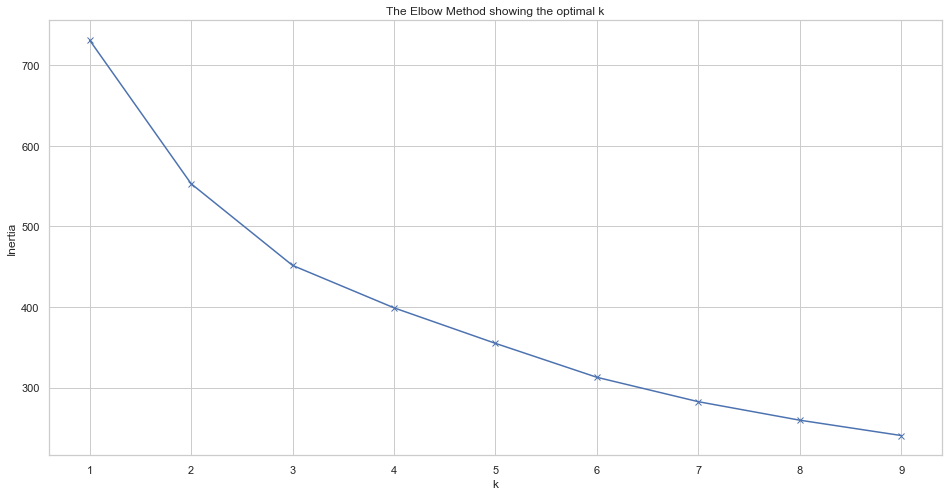

In [62]:
# Elbow method to determine the optimal number of clusters for k-means

import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

act_dm = UserAtivFinal[:]
act_dm = act_dm.drop(columns=['sessionkey', 'time_request', 'execution_count', 'score',
                              'sessionkey', 'time_request', 'DC6+_volt', 'DC6+_cur', 
                              'DC25+_volt', 'DC25+_cur', 'DC25-_volt', 'DC25-_cur', 'time_difference',
                              'error_id', 'error_esp'
                            ])

# Load your data
elbow_df = act_dm[:]

# Only discriminatory variables (with more than one value)
elbow_df = elbow_df.drop(columns=['exp_id'])


# Perform K-means clustering with different numbers of clusters
inertia = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=10)
    kmeanModel.fit(elbow_df)
    inertia.append(kmeanModel.inertia_)

# Plot the elbow
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()


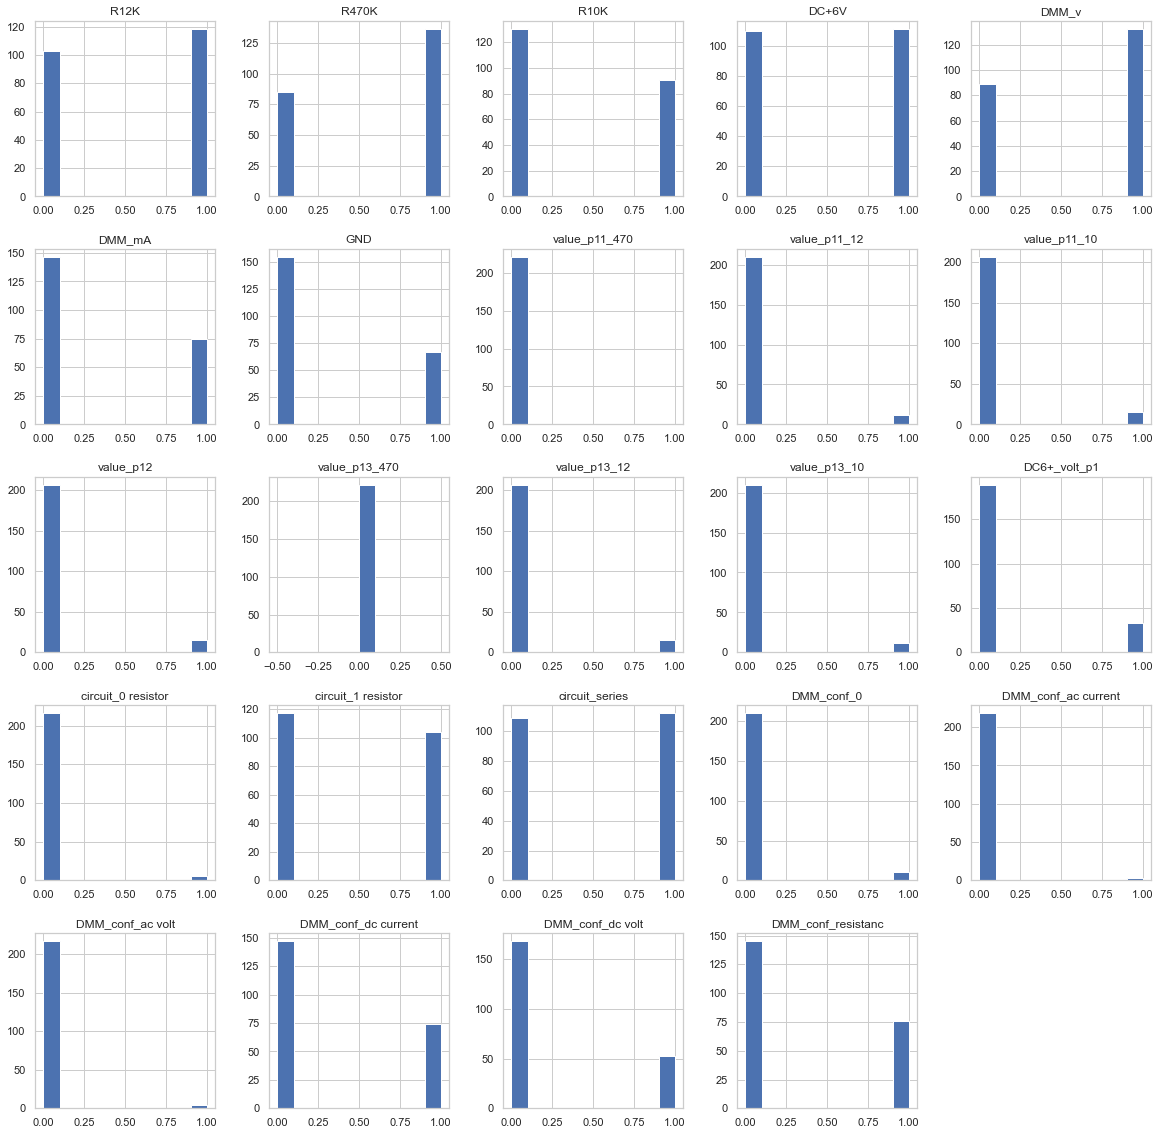

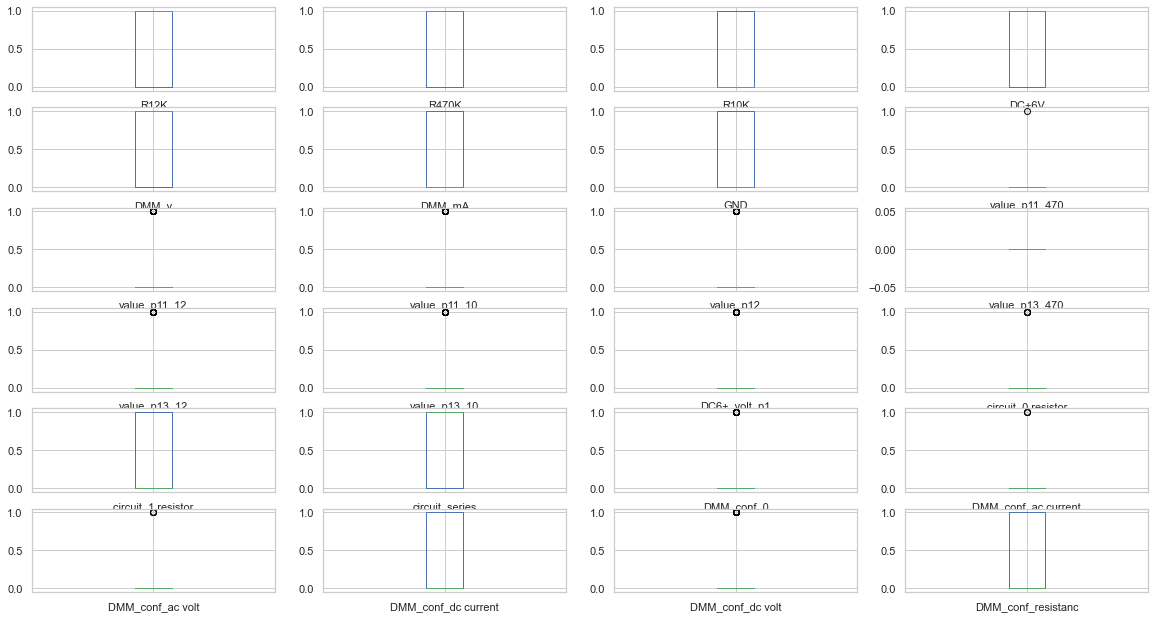

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your data is in a pandas DataFrame named df
act_k = act_dm[:]  # replace with your actual data

# Descriptive analysis
#print('\nDescriptive Analysis: ',df.describe().round(2))

# Information about the variables
#print('\nVariable´s Information: ',df.info())

# Visualization
# Histograms for each attribute
act_k.hist(figsize=(20, 20))
plt.show()

# Box and whisker plots for each attribute
act_k.plot(kind='box', subplots=True, layout=(11,4), sharex=False, sharey=False, figsize=(20,20))
plt.show()

In [64]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Initialize an empty DataFrame to store the results
result_df = pd.DataFrame()

# Loop through unique 'exp_id' values
for exp_id in act_k['exp_id'].unique():
    # Filter the DataFrame for the current 'exp_id'
    subset_df = act_k[act_k['exp_id'] == exp_id].copy()

    # Extract binary features for clustering
    binary_features = subset_df.drop(['exp_id'], axis=1)

    # Check if the number of samples is greater than or equal to the desired number of clusters
    if len(binary_features) >= 4:
        # Standardize the features
        scaler = StandardScaler()
        binary_features_scaled = pd.DataFrame(scaler.fit_transform(binary_features), columns=binary_features.columns)

        # Perform K-means clustering with n_clusters=4
        n_clusters = 3
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        subset_df['cluster_k'] = kmeans.fit_predict(binary_features_scaled)
               
        # Append the results to the main DataFrame
        result_df = pd.concat([result_df, subset_df], ignore_index=True)
        
    else:
        print(f"Skipping exp_id {exp_id} due to insufficient samples for clustering.")
        

# Check the size of each cluster per exp_id
cluster_sizes_k = result_df.groupby(['exp_id', 'cluster_k']).size().reset_index(name='cluster_sizes_k')

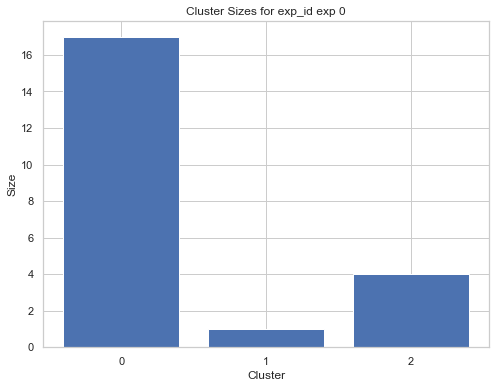

<Figure size 432x288 with 0 Axes>

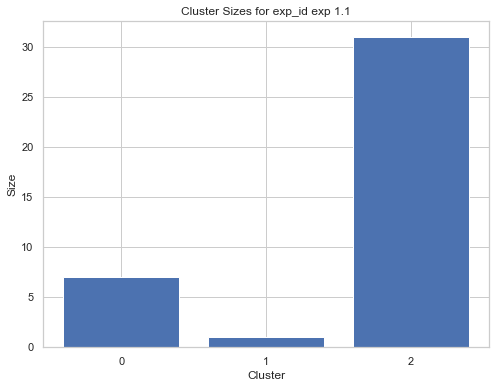

<Figure size 432x288 with 0 Axes>

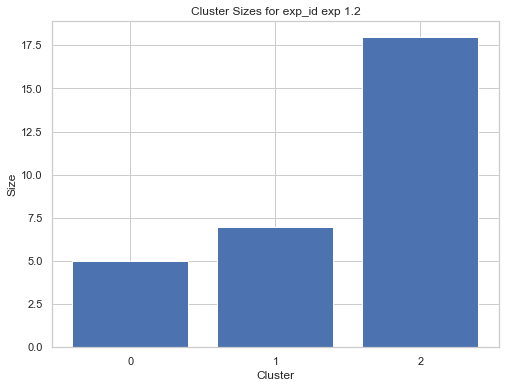

<Figure size 432x288 with 0 Axes>

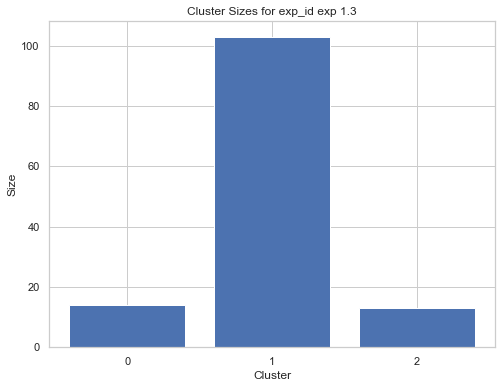

<Figure size 432x288 with 0 Axes>

In [66]:
import matplotlib.pyplot as plt
import os

# Set the style of seaborn for better aesthetics
sns.set(style="whitegrid")

# Create a directory to store the plots
output_dir = "kmeans_exp"
os.makedirs(output_dir, exist_ok=True)

# Group the data by 'exp_id' and 'cluster_k', and calculate the size of each cluster
cluster_sizes_k = result_df.groupby(['exp_id', 'cluster_k']).size().reset_index(name='cluster_sizes_k')

# Plot the cluster sizes for each 'exp_id'
for exp_id in cluster_sizes_k['exp_id'].unique():
    exp_data = cluster_sizes_k[cluster_sizes_k['exp_id'] == exp_id]
    plt.figure(figsize=(8, 6))
    plt.bar(exp_data['cluster_k'], exp_data['cluster_sizes_k'])
    plt.title(f'Cluster Sizes for exp_id {exp_id}')
    plt.xlabel('Cluster')
    plt.ylabel('Size')
    plt.xticks(exp_data['cluster_k'])
    plt.show()
    
    output_file = os.path.join(output_dir, f"kmeans{exp_id}.png")
    plt.savefig(output_file)


In [67]:
# Create a directory to store the plots
output_dir = "cluster_size_plots"
os.makedirs(output_dir, exist_ok=True)

# Plot the cluster sizes for each 'exp_id' and save them as image files
for exp_id in cluster_sizes_k['exp_id'].unique():
    exp_data = cluster_sizes_k[cluster_sizes_k['exp_id'] == exp_id]
    plt.figure(figsize=(8, 6))
    plt.bar(exp_data['cluster_k'], exp_data['cluster_sizes_k'])
    plt.title(f'Cluster Sizes for exp_id {exp_id}')
    plt.xlabel('Cluster')
    plt.ylabel('Size')
    plt.xticks(exp_data['cluster_k'])
    
    # Save the plot to a file
    output_file = os.path.join(output_dir, f"cluster_size_plot_exp_{exp_id}.png")
    plt.savefig(output_file)
    plt.close()

# Generate download links for the saved plots
download_links = []
for exp_id in cluster_sizes_k['exp_id'].unique():
    output_file = f"cluster_size_plot_exp_{exp_id}.png"
    download_links.append((f"Download Cluster Size Plot for exp_id {exp_id}", output_file))

# Display the download links
for link_text, file_name in download_links:
    display_link = pn.widgets.FileDownload(filename=file_name, label=link_text)
    display_link.servable()


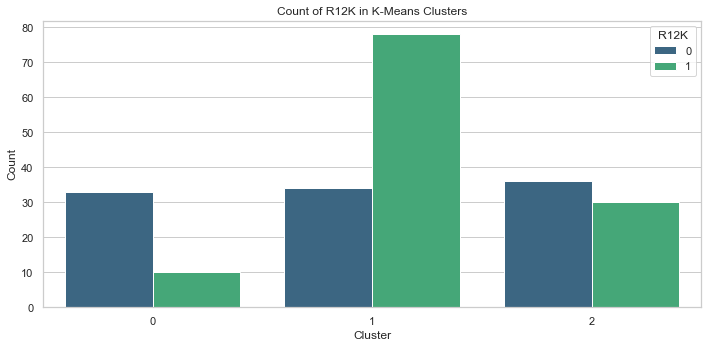

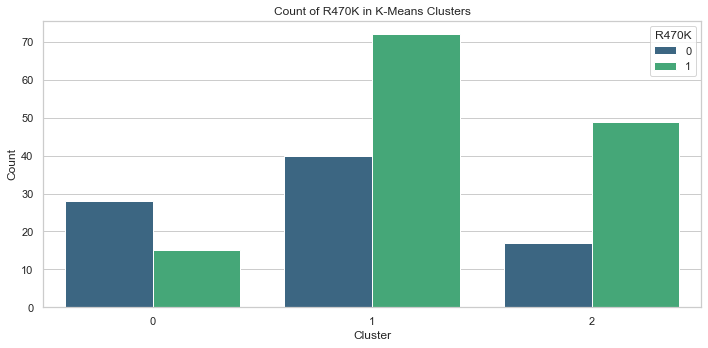

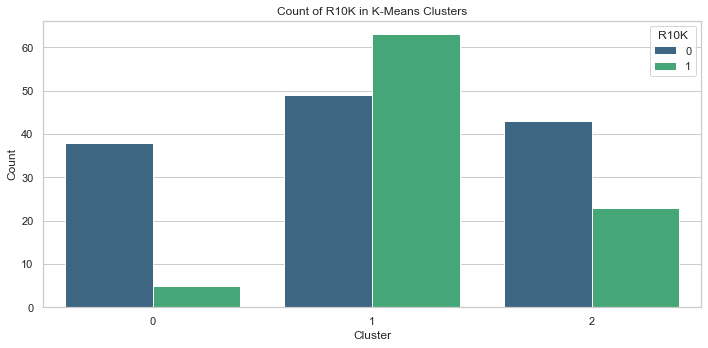

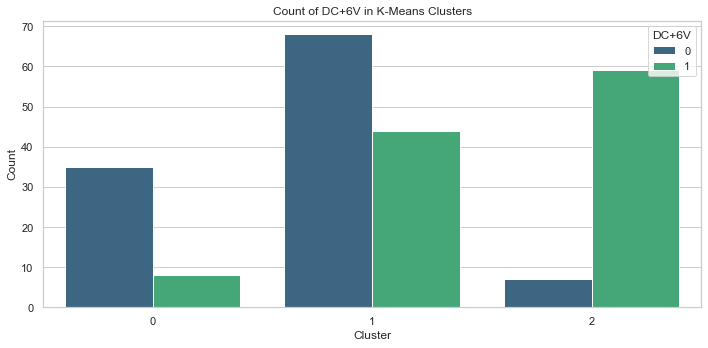

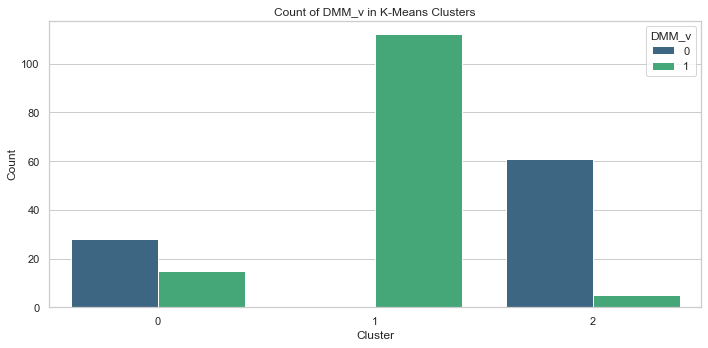

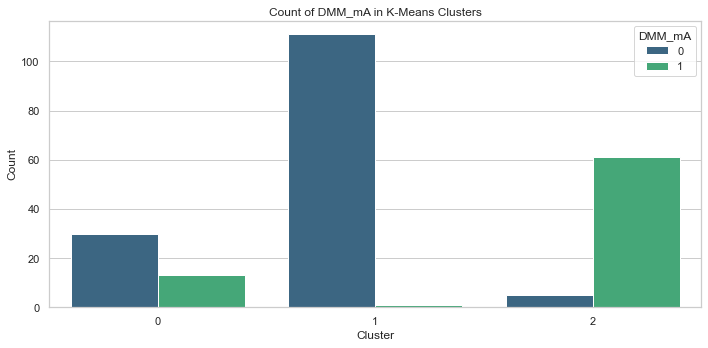

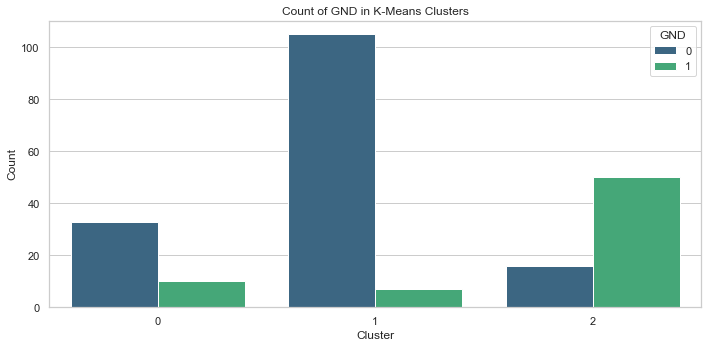

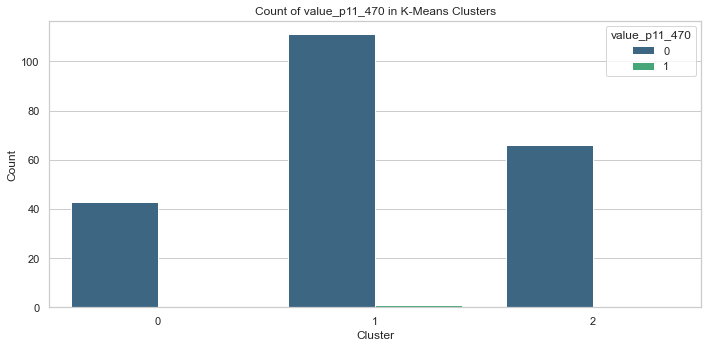

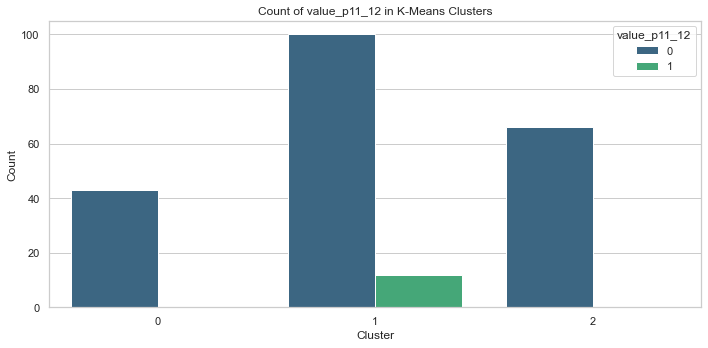

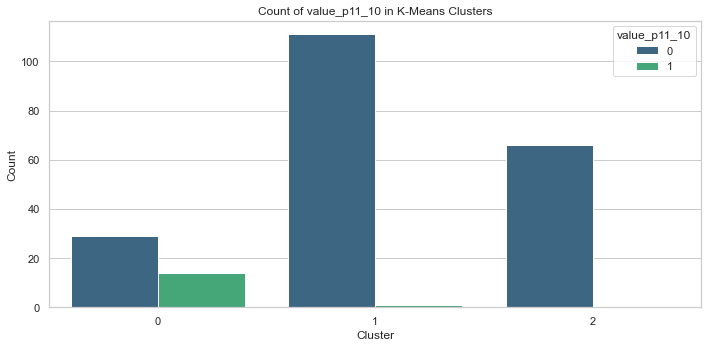

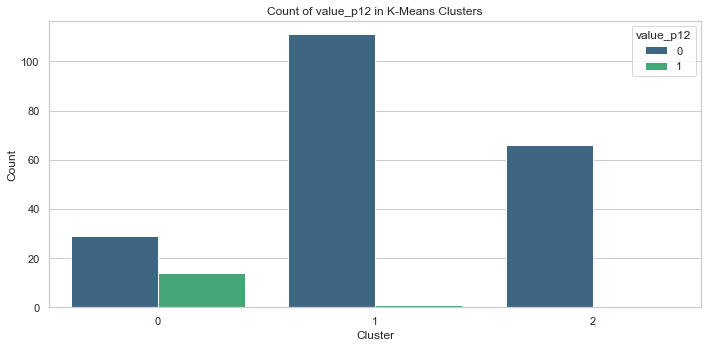

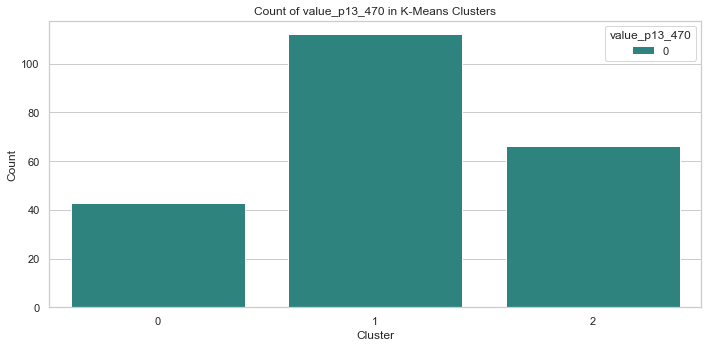

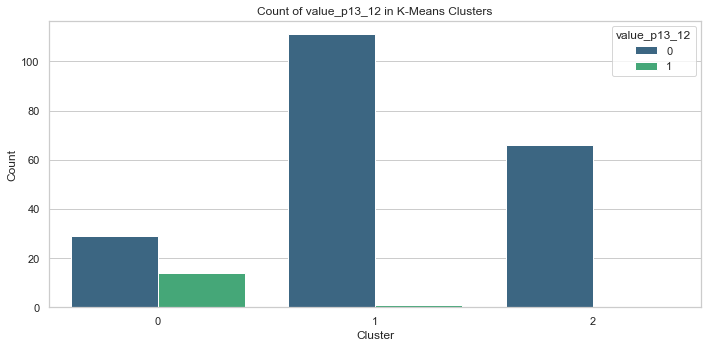

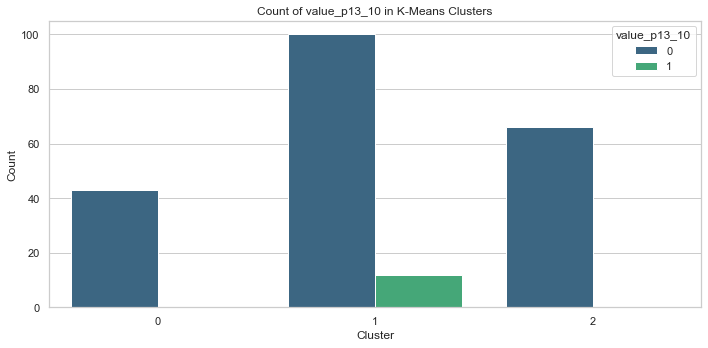

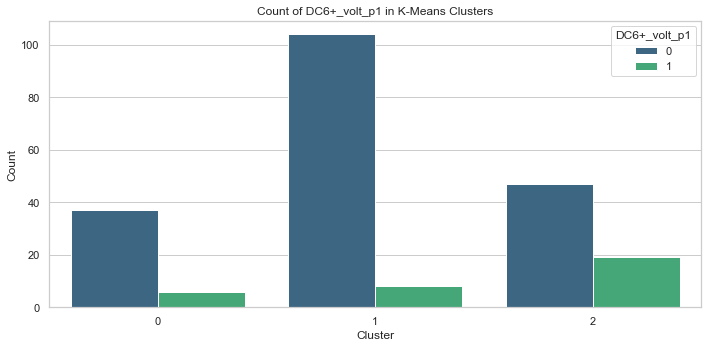

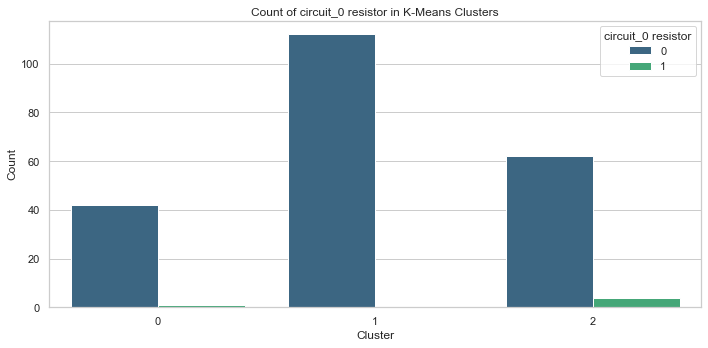

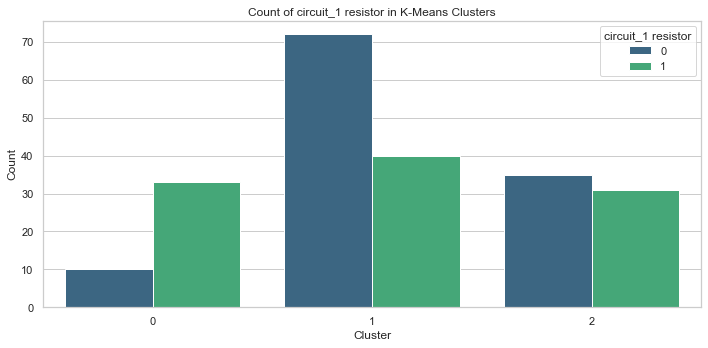

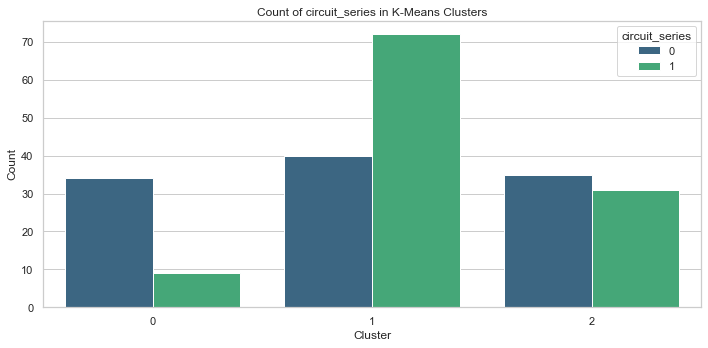

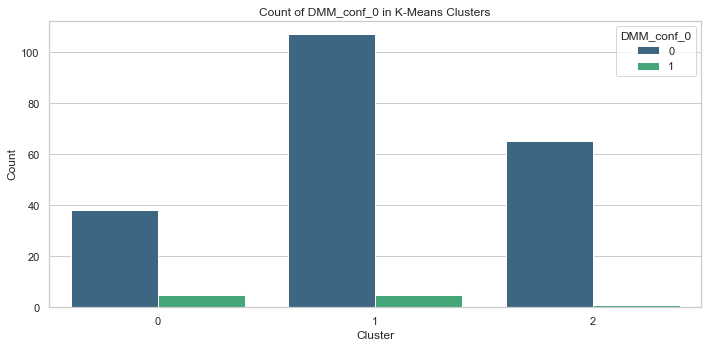

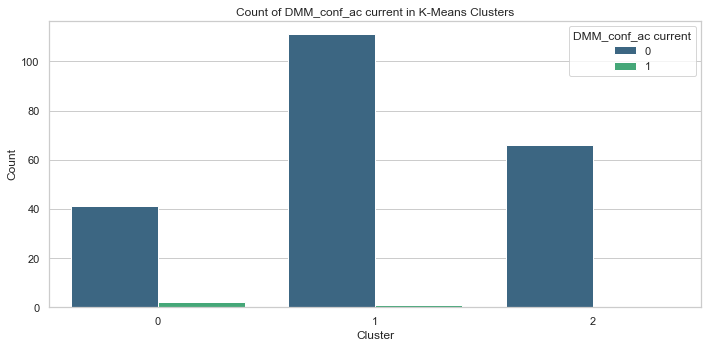

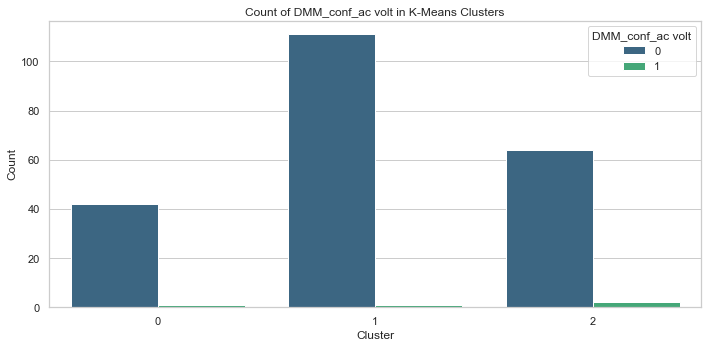

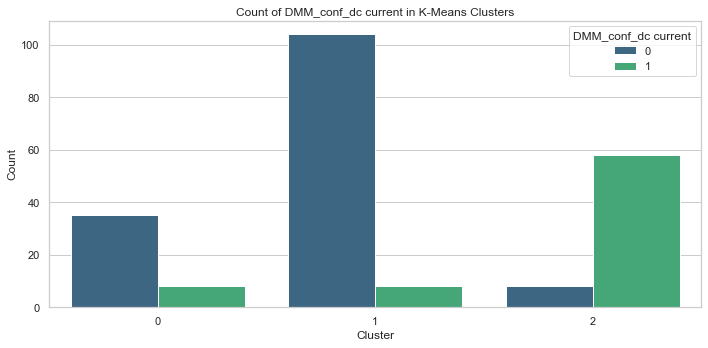

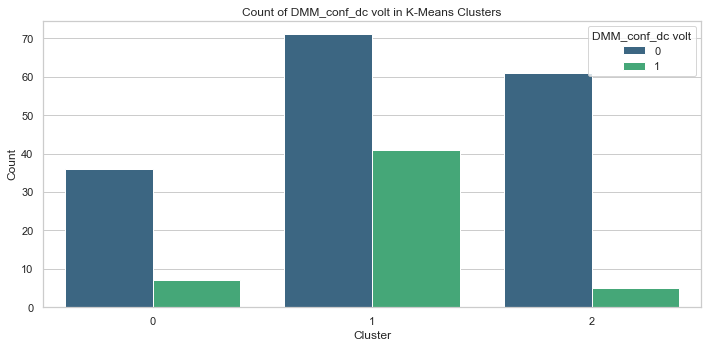

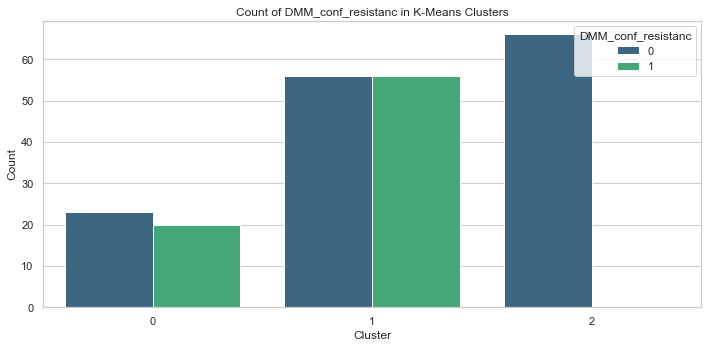

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn for better aesthetics
sns.set(style="whitegrid")

# Loop through each variable and create a count plot for each variable per exp_id
for variable in result_df.drop(['exp_id', 'cluster_k'], axis=1).columns:
    plt.figure(figsize=(10, 5))
    
    # Plot K-Means clusters
    sns.countplot(x='cluster_k', hue=variable, data=result_df, palette='viridis', dodge=True)
    plt.title(f'Count of {variable} in K-Means Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.legend(title=variable, loc='upper right')

    plt.tight_layout()
    plt.show()


In [69]:
#------------PARA SALVAR OS GRAFICOS AUTOMATICO--------
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn for better aesthetics
sns.set(style="whitegrid")

# Create a directory to save plots if it doesn't exist
output_dir = 'plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop through each variable and create a bar plot for each cluster
for i, variable in enumerate(result_df):
    plt.figure(figsize=(10, 5))
    
    # Plot K-Means clusters
    plt.subplot(1, 2, 1)
    sns.countplot(x='cluster_k', hue=variable, data=result_df, palette='viridis')
    plt.title(f'Count of {variable} in K-Means Clusters')

    plt.tight_layout()
    
    # Save the plot
    filename = os.path.join(output_dir, f'plot_{i}.png')
    plt.savefig(filename)
    plt.close()  # Close the figure to release memory

# After generating all plots, you can compress them into a zip file for easier downloading
import shutil
shutil.make_archive(output_dir, 'zip', output_dir)


'C:\\Users\\carin\\Documents\\LEDA\\plots.zip'

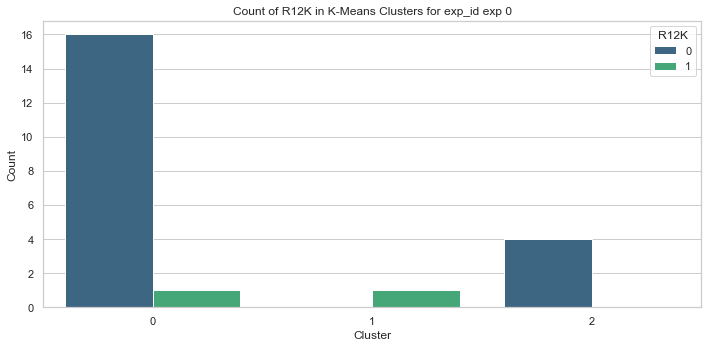

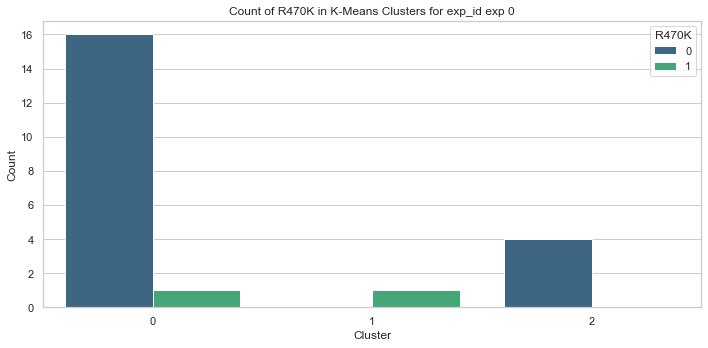

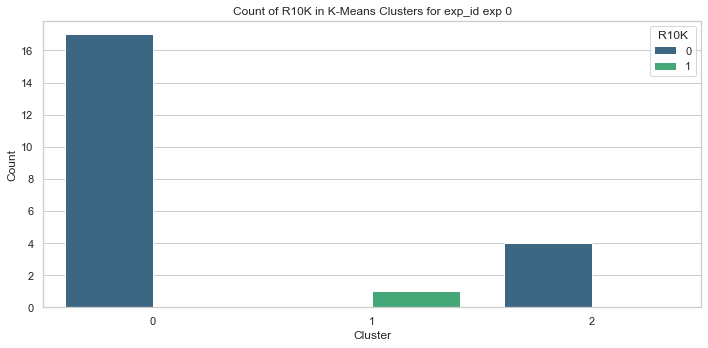

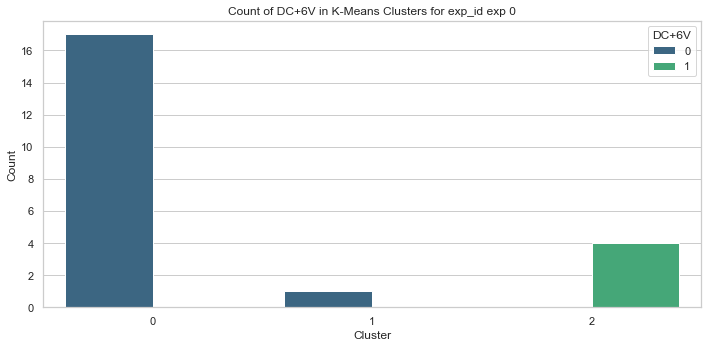

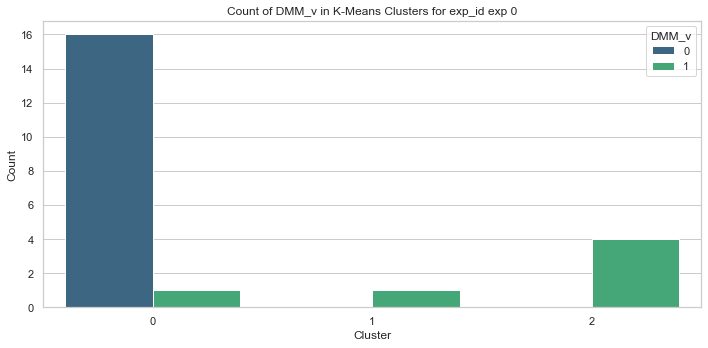

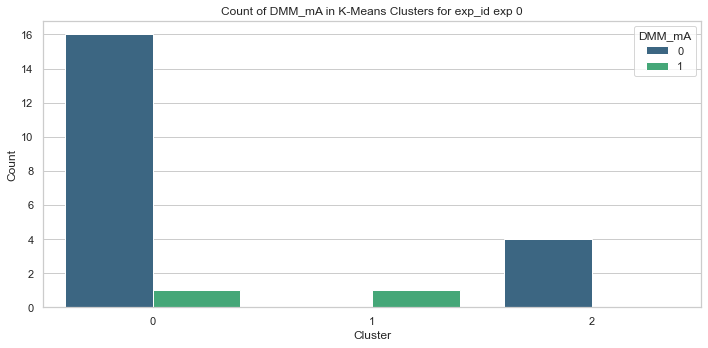

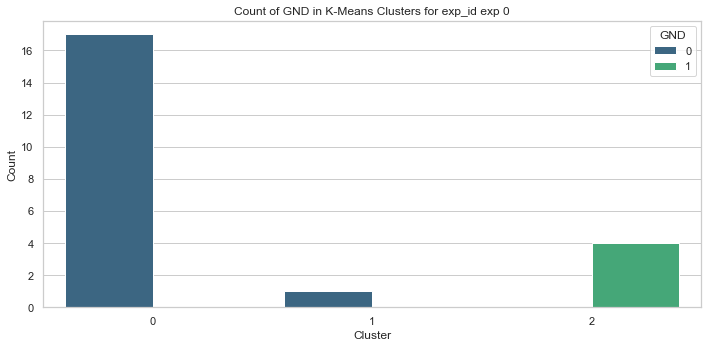

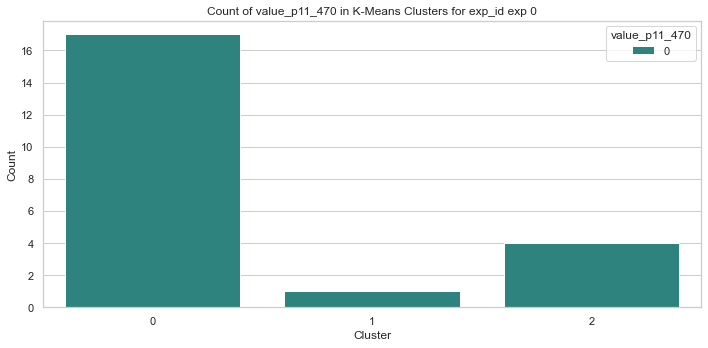

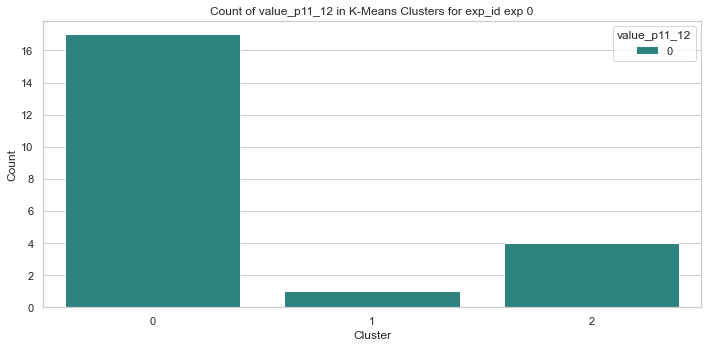

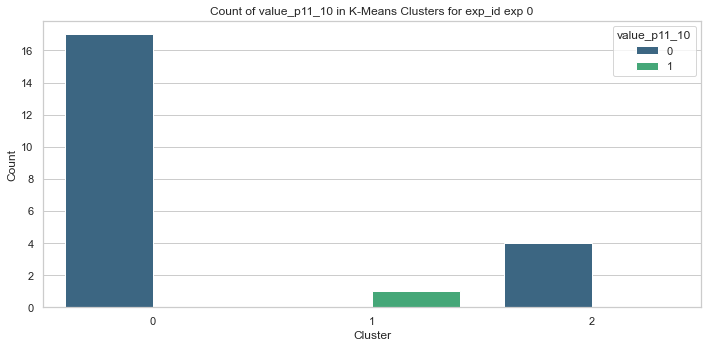

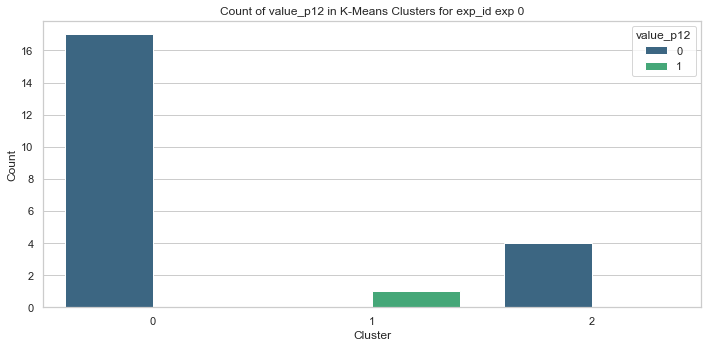

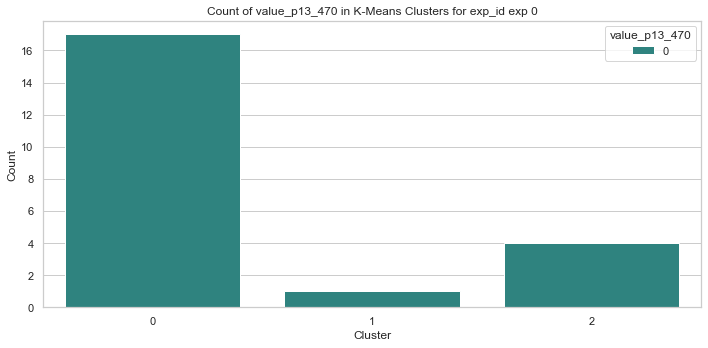

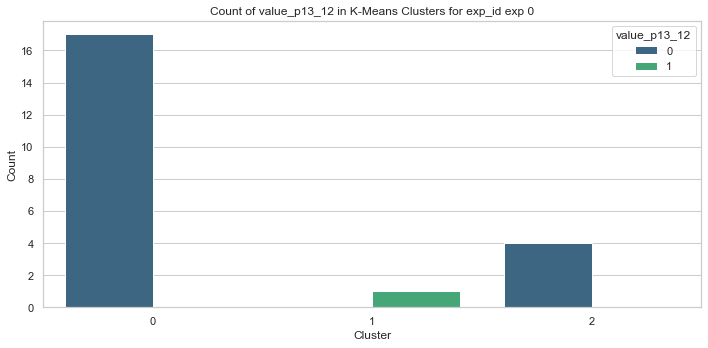

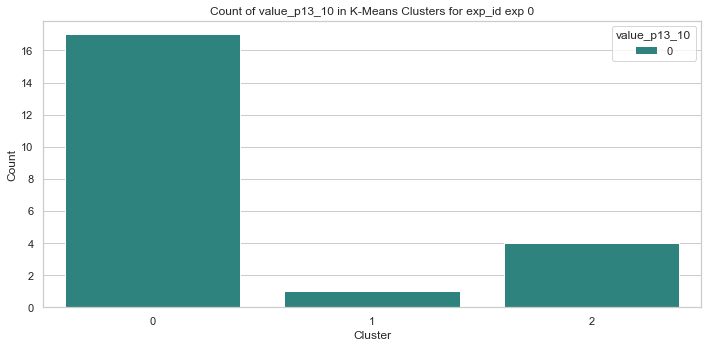

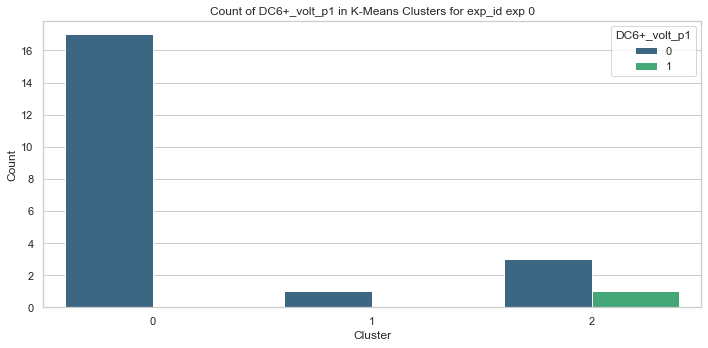

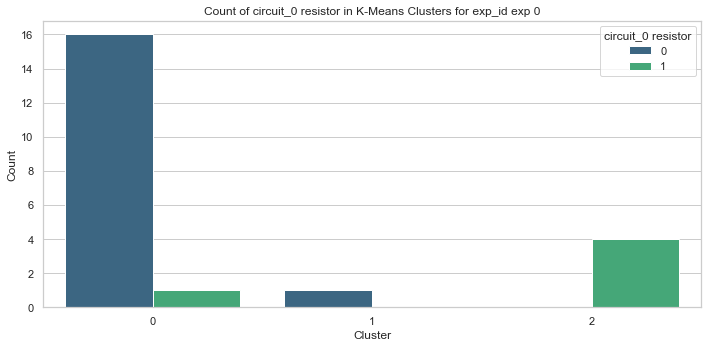

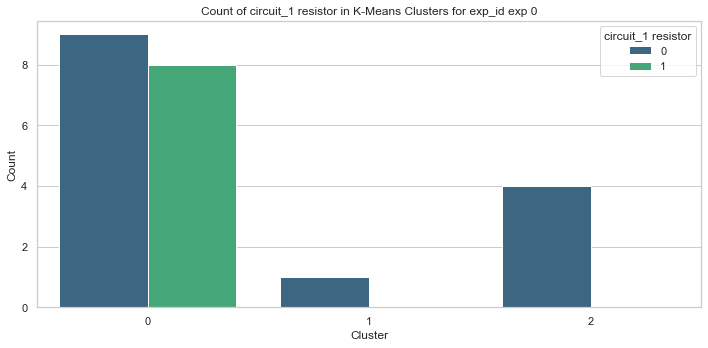

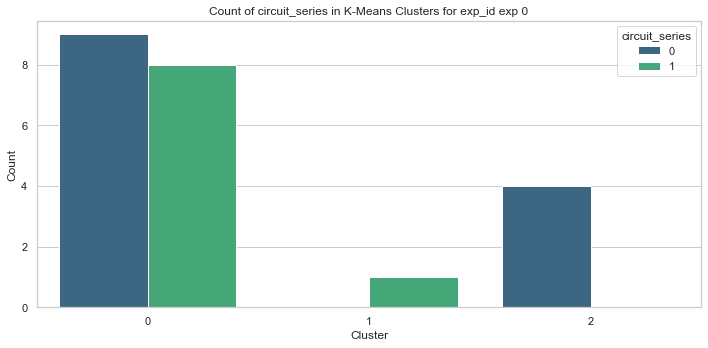

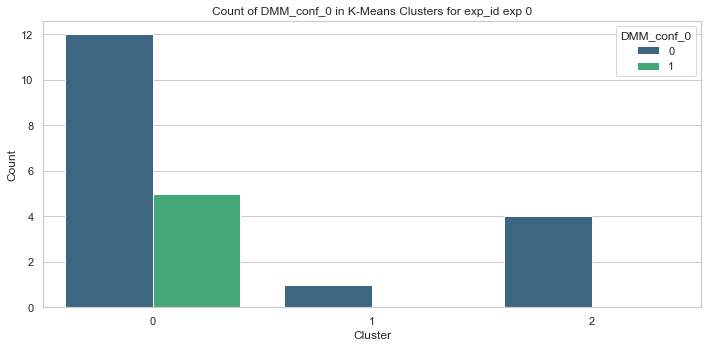

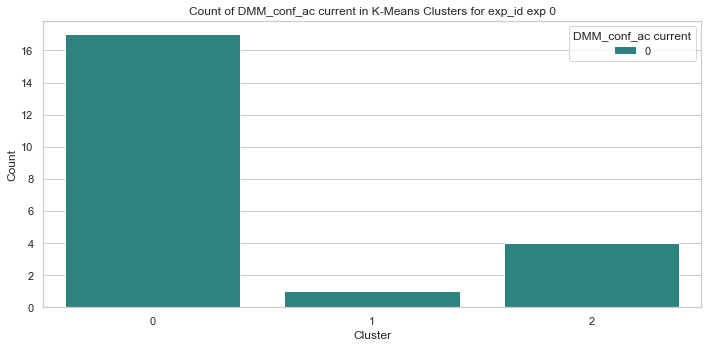

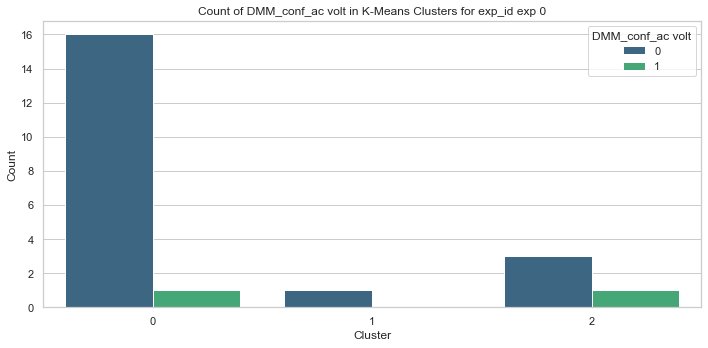

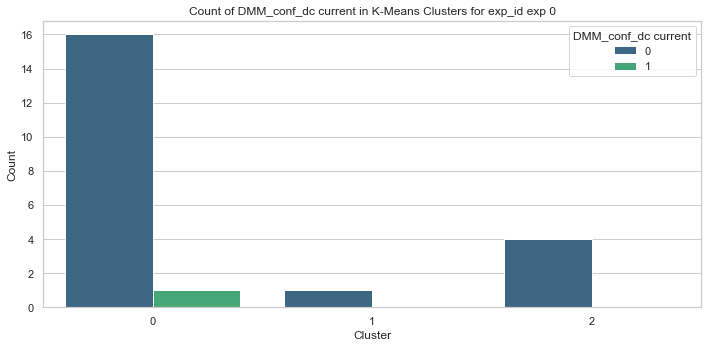

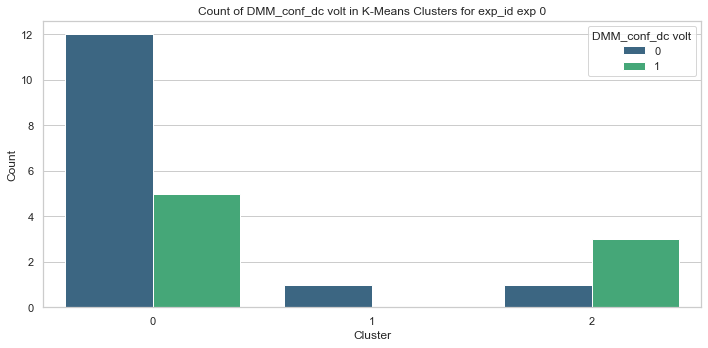

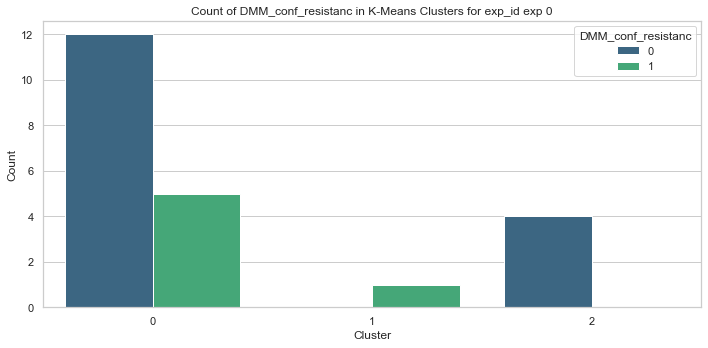

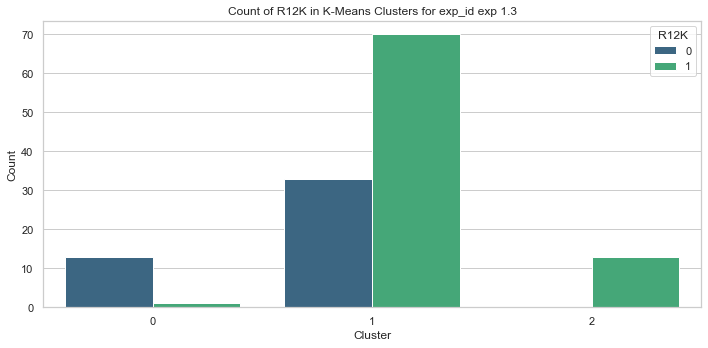

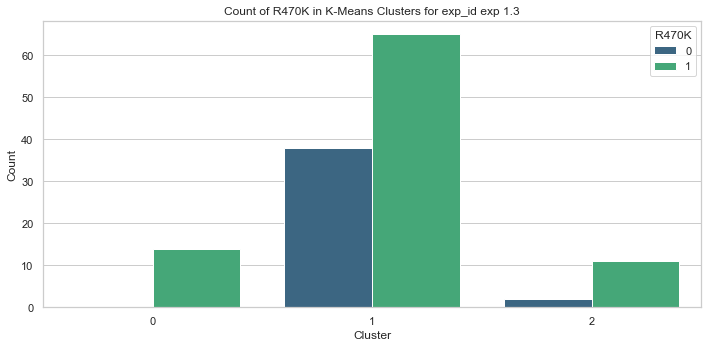

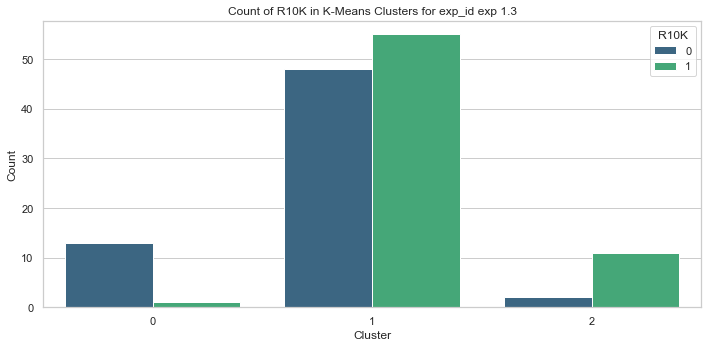

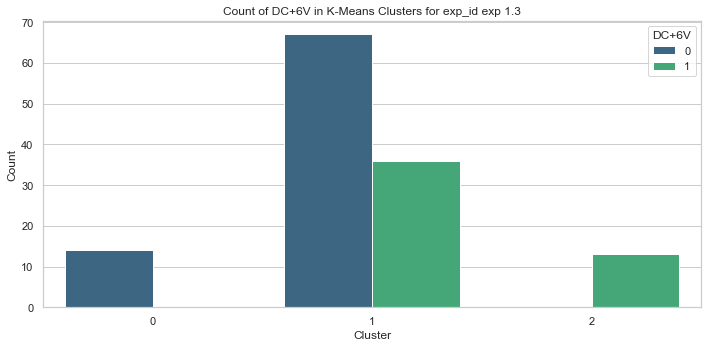

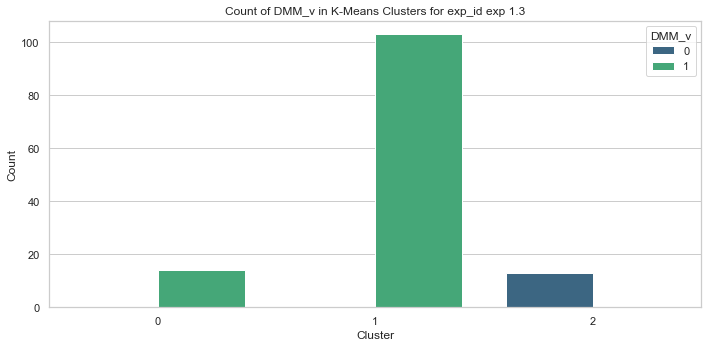

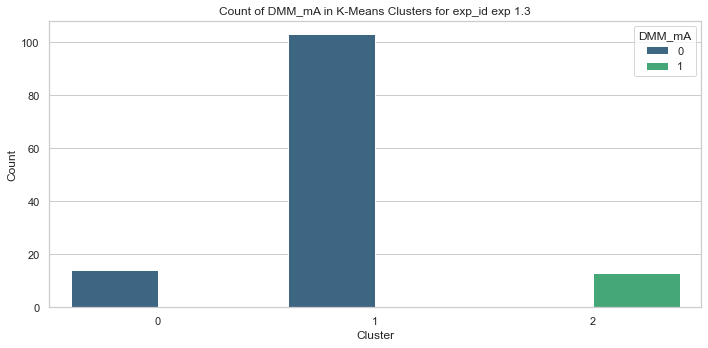

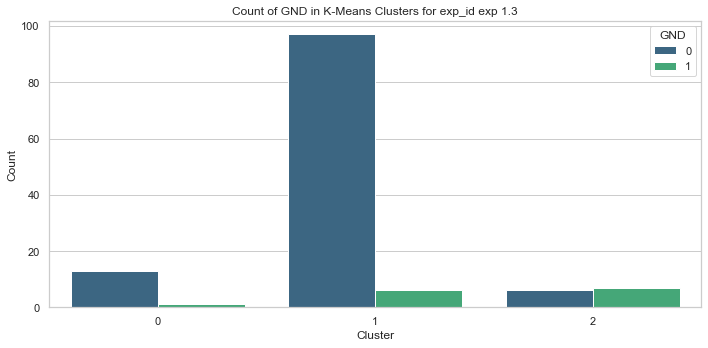

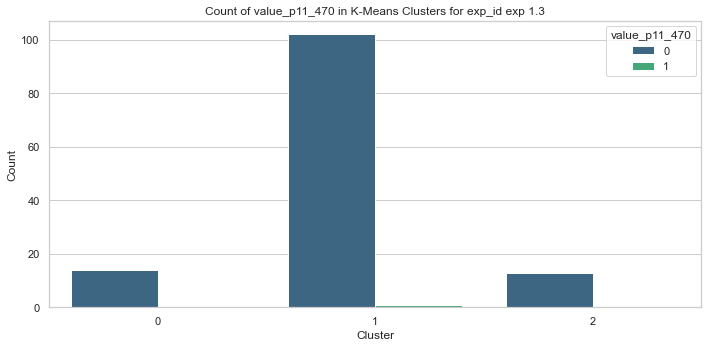

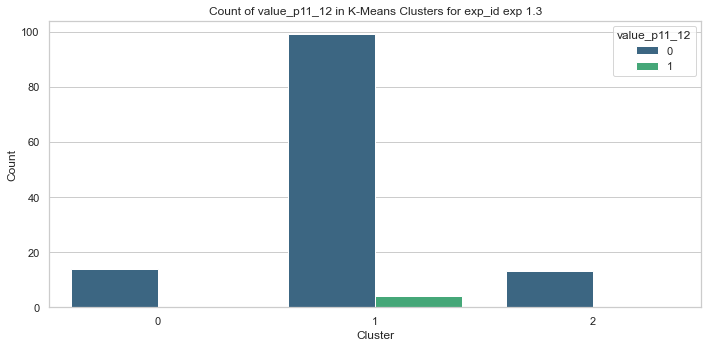

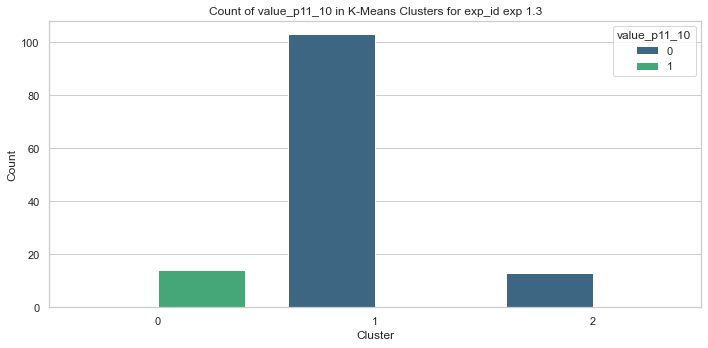

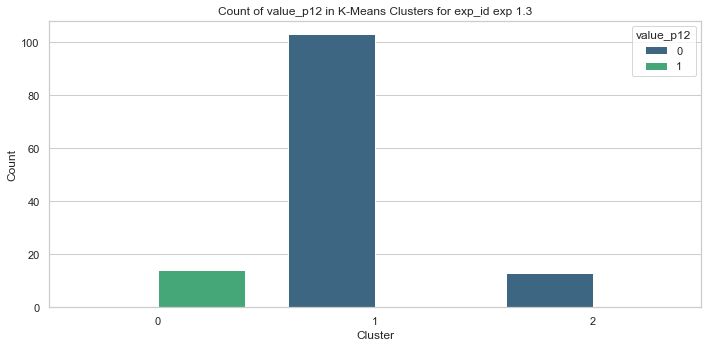

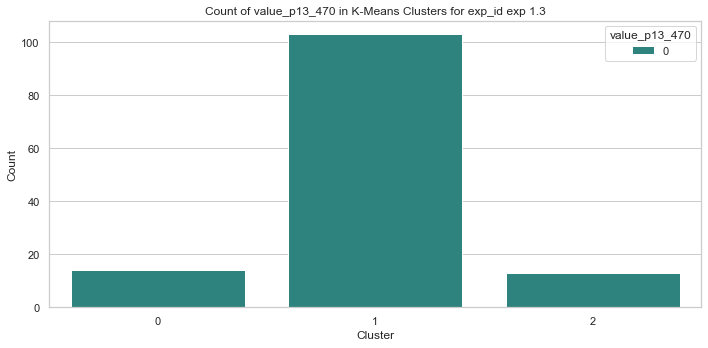

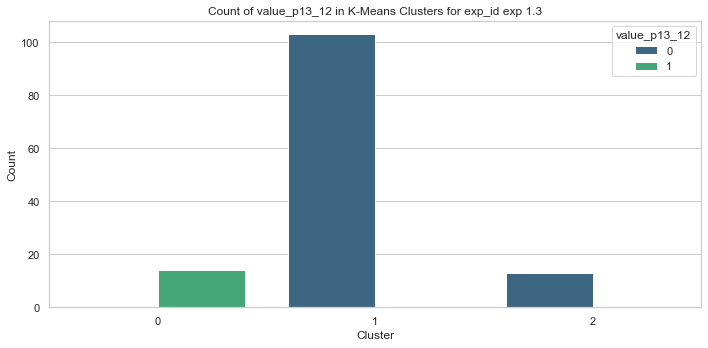

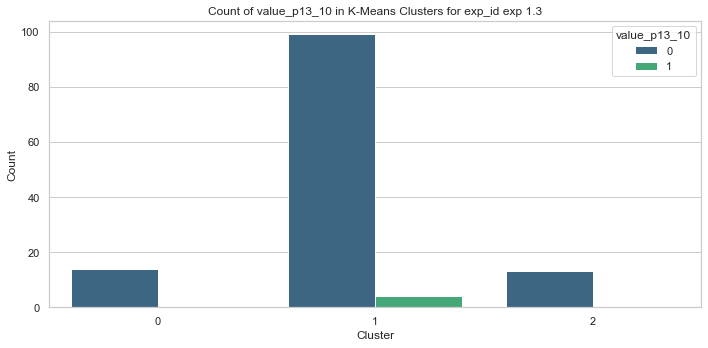

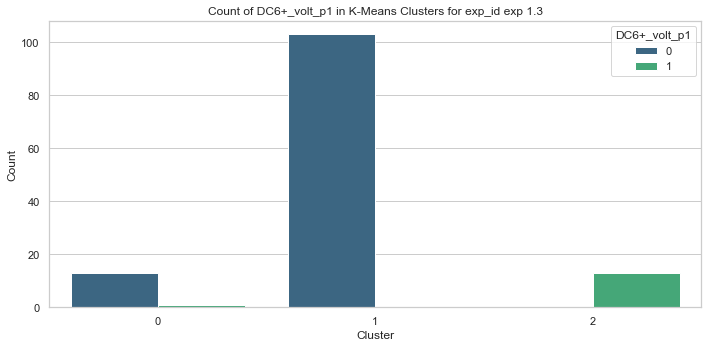

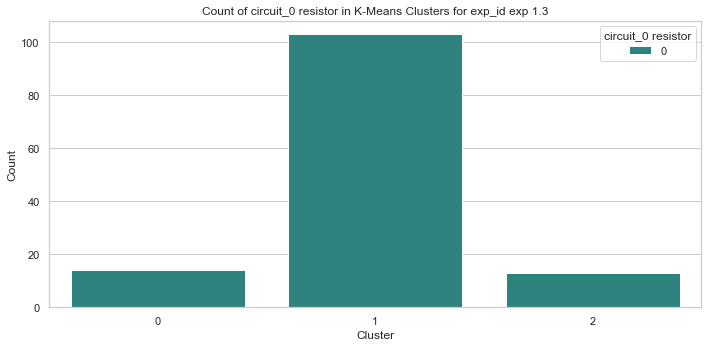

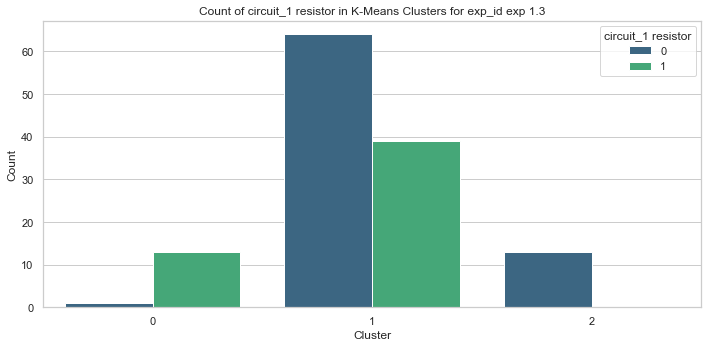

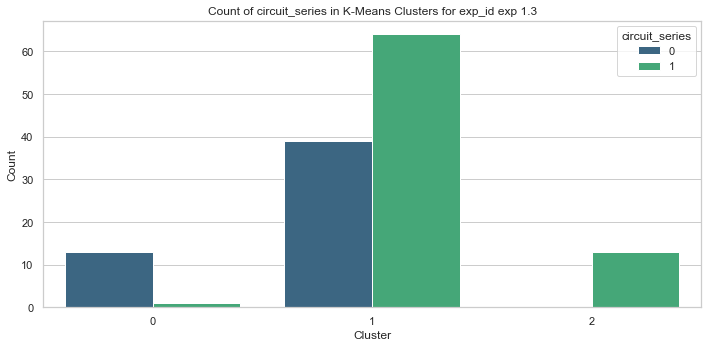

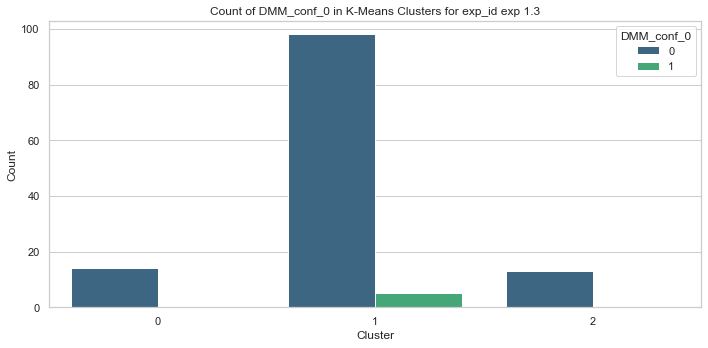

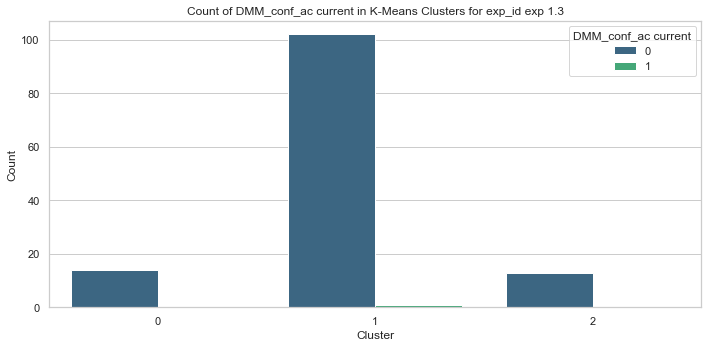

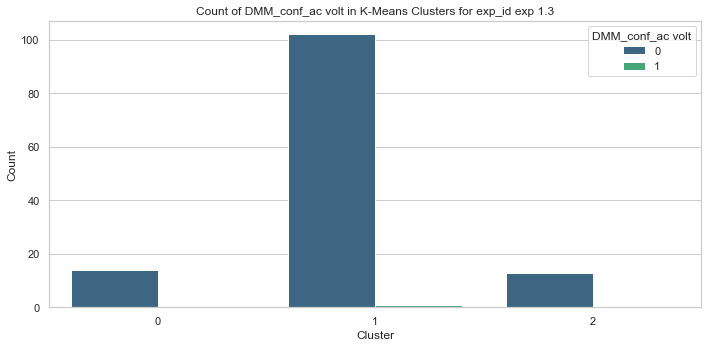

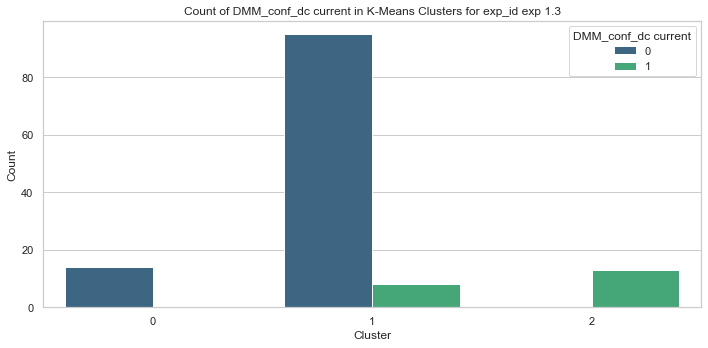

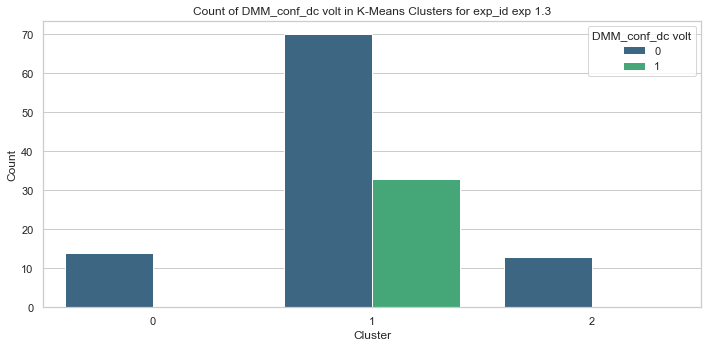

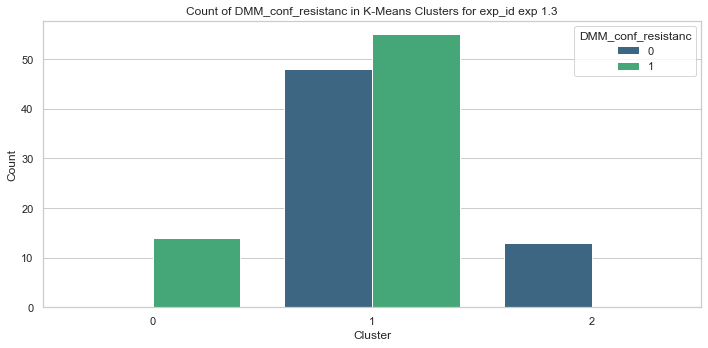

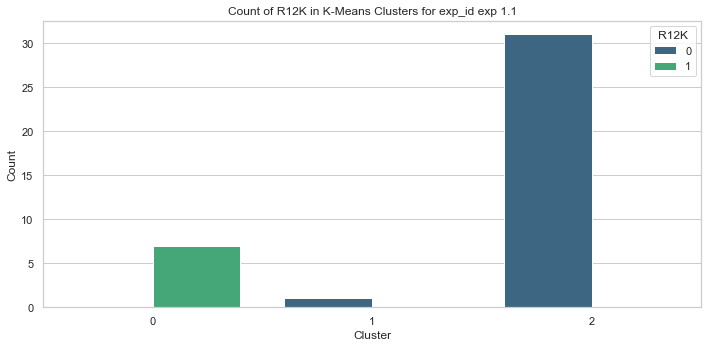

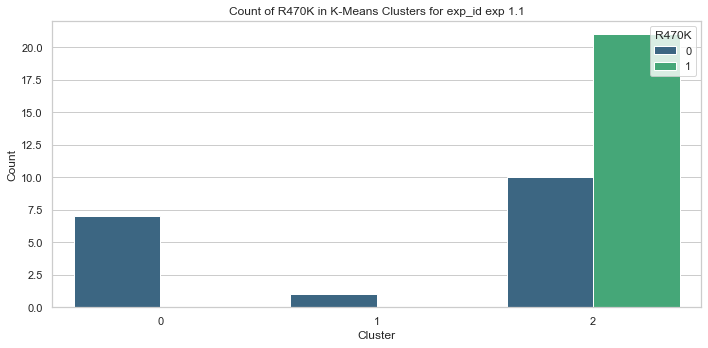

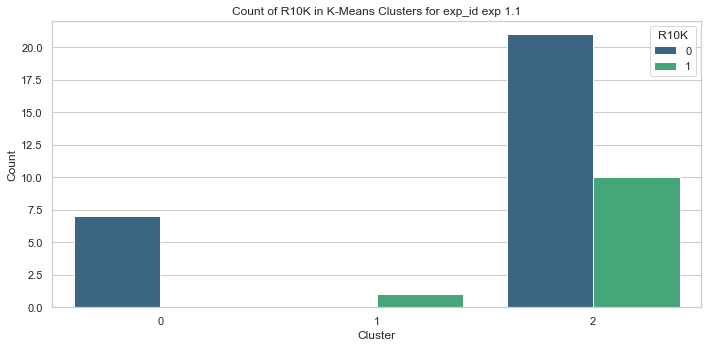

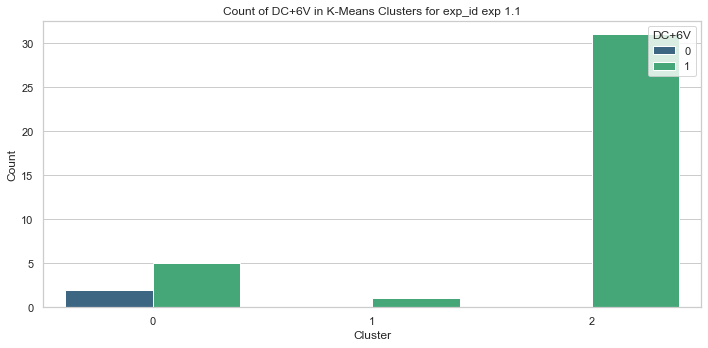

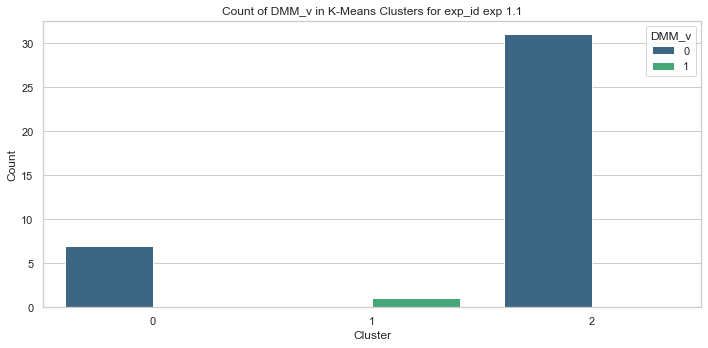

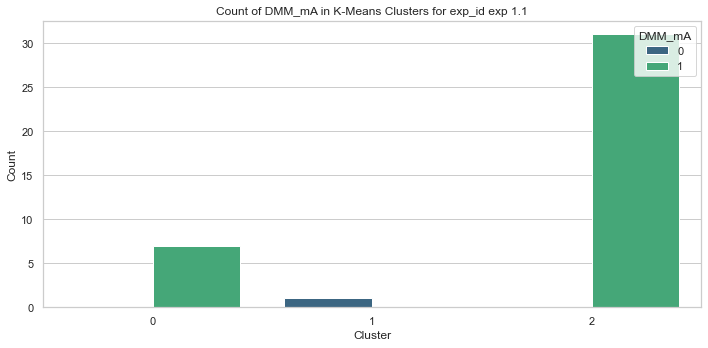

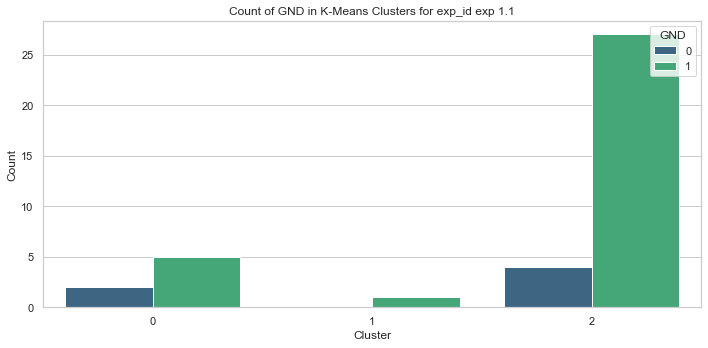

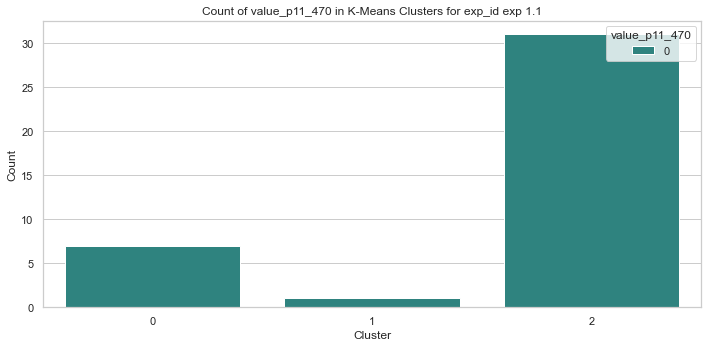

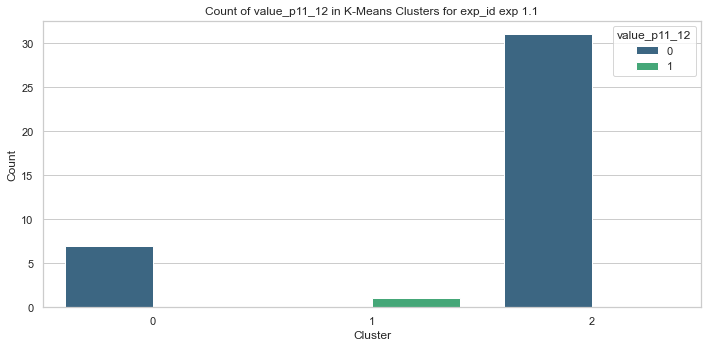

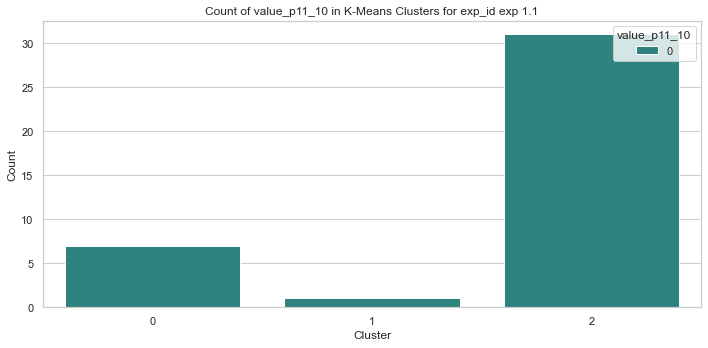

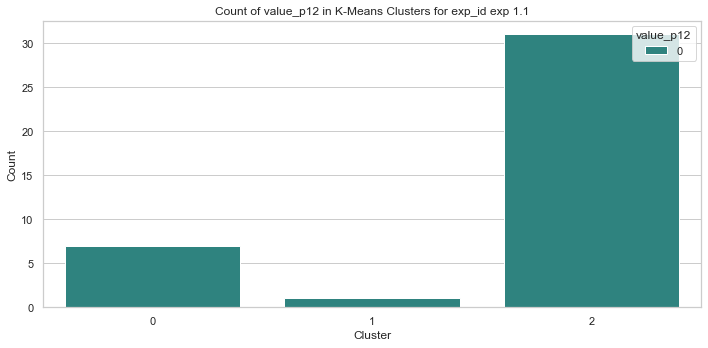

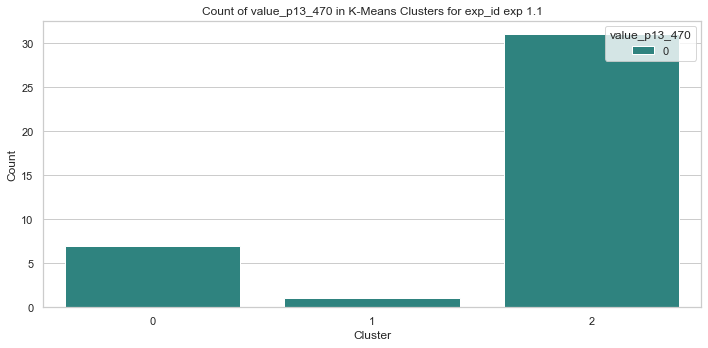

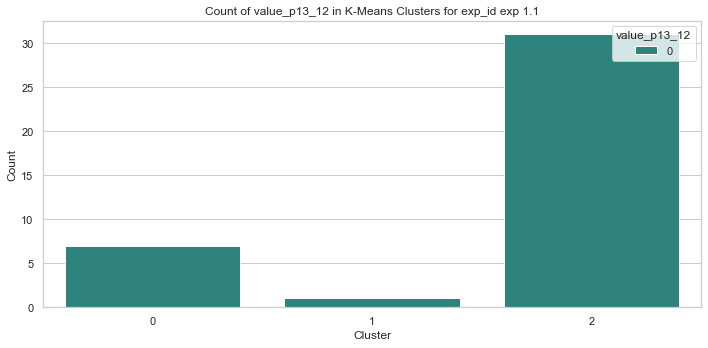

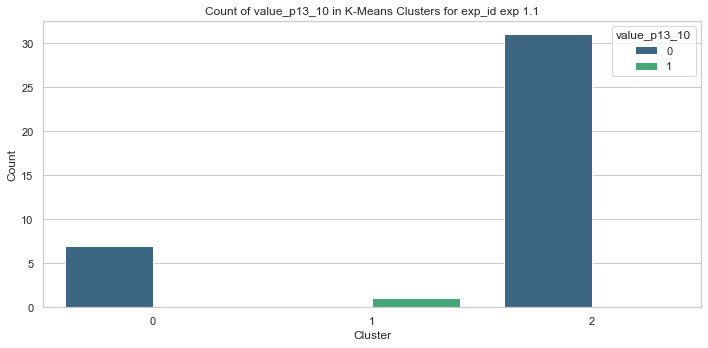

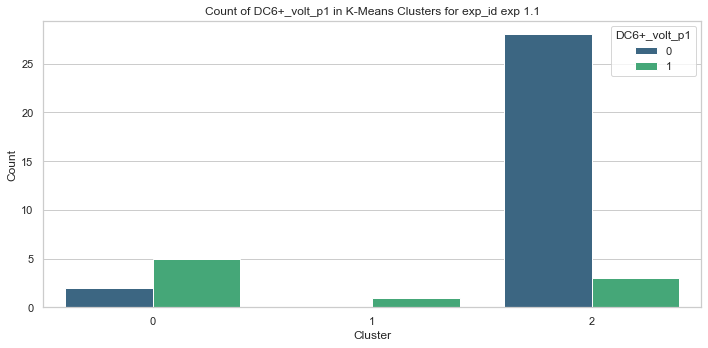

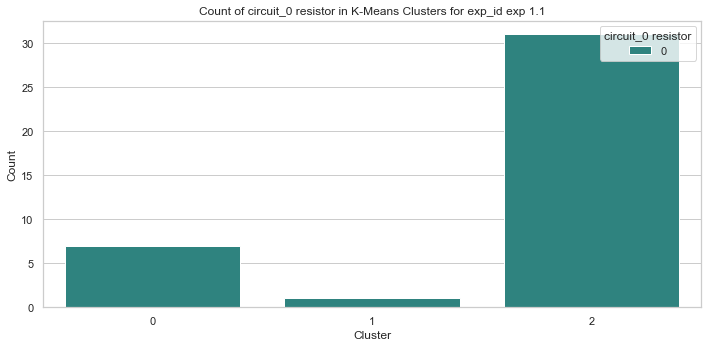

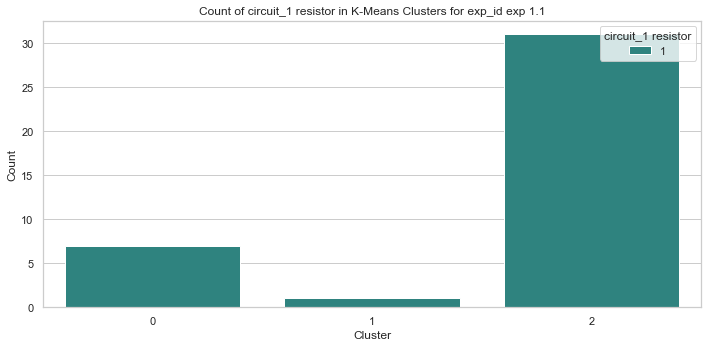

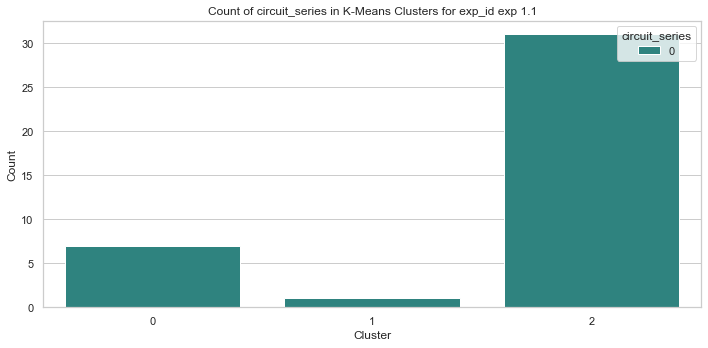

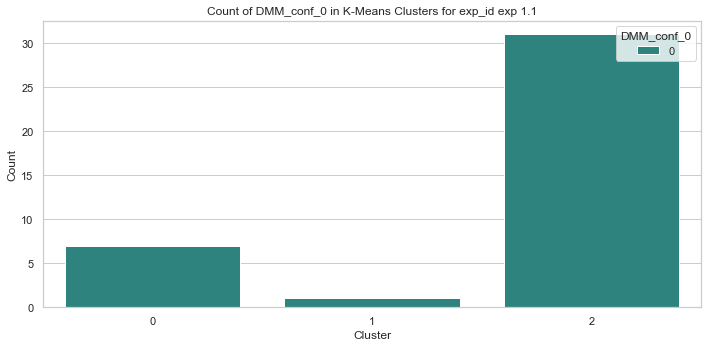

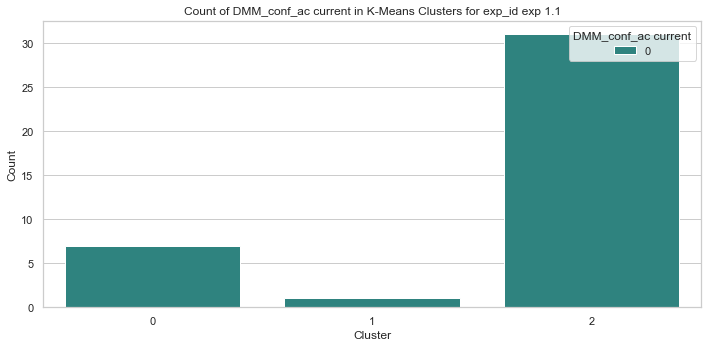

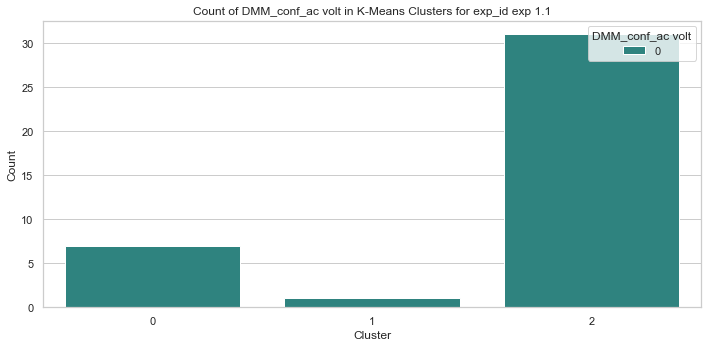

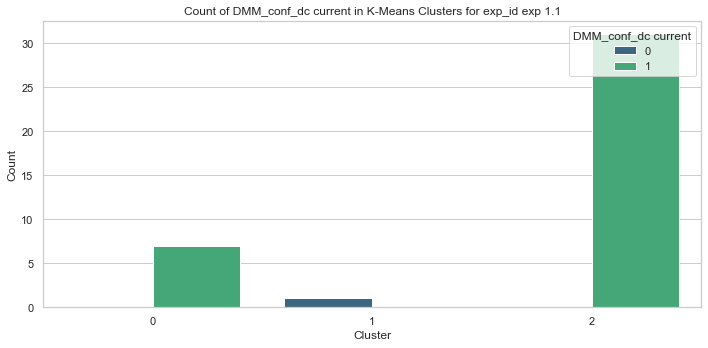

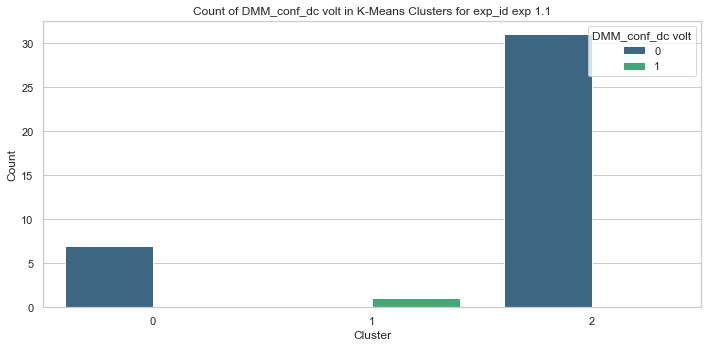

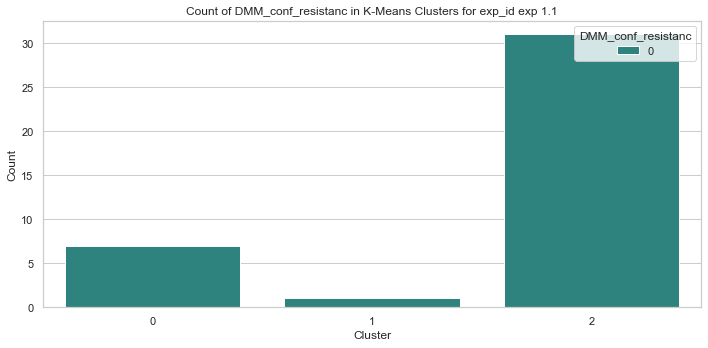

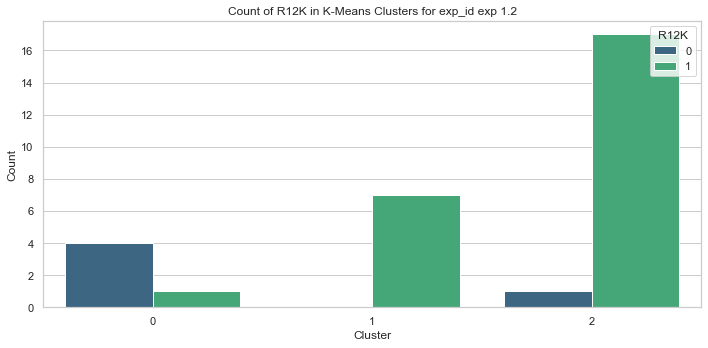

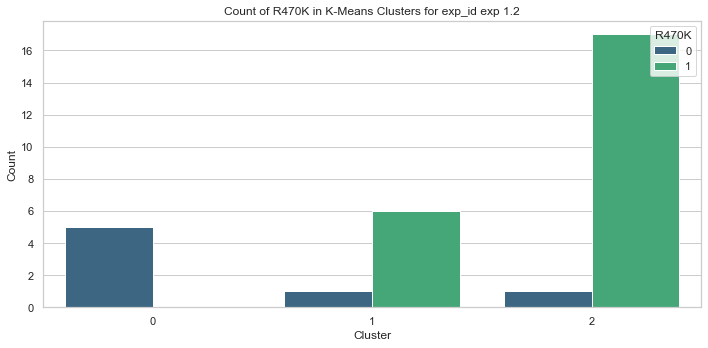

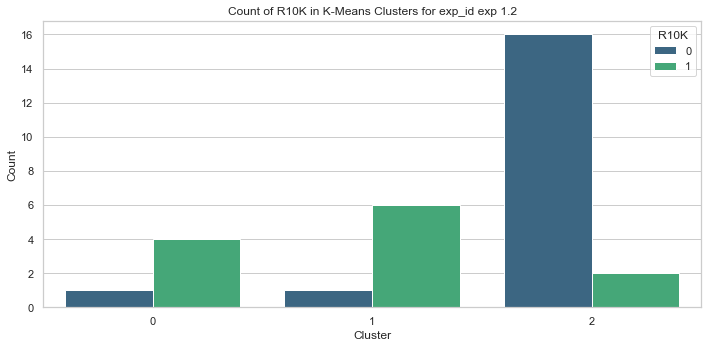

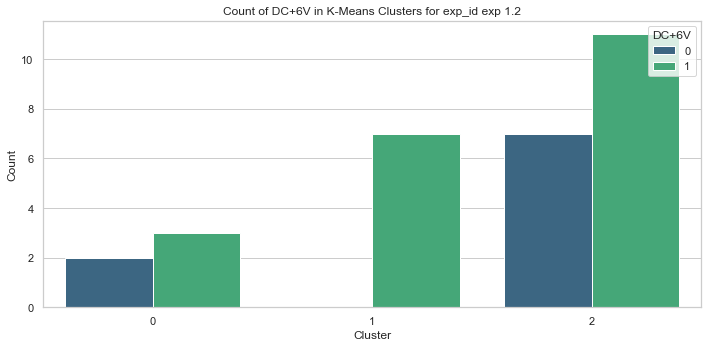

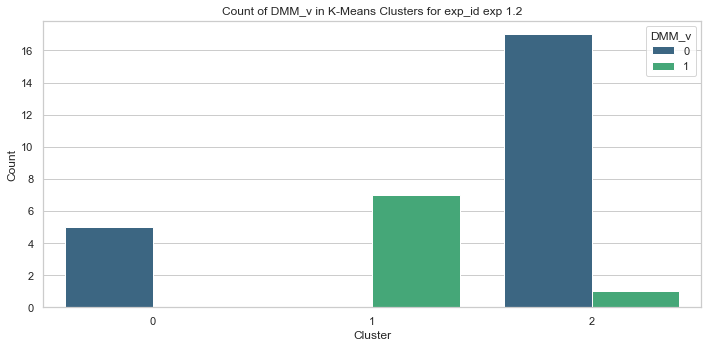

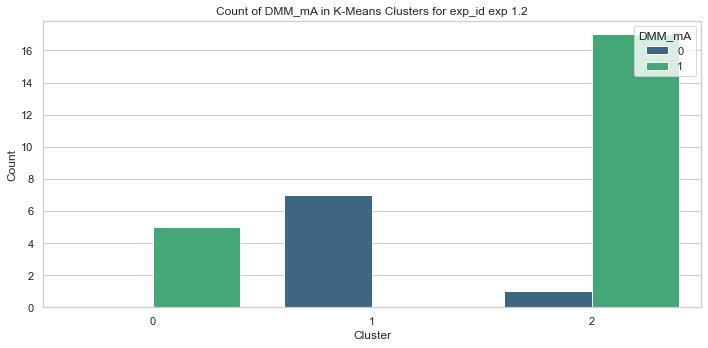

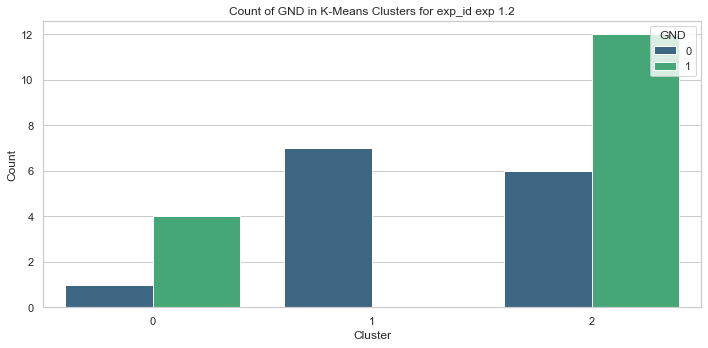

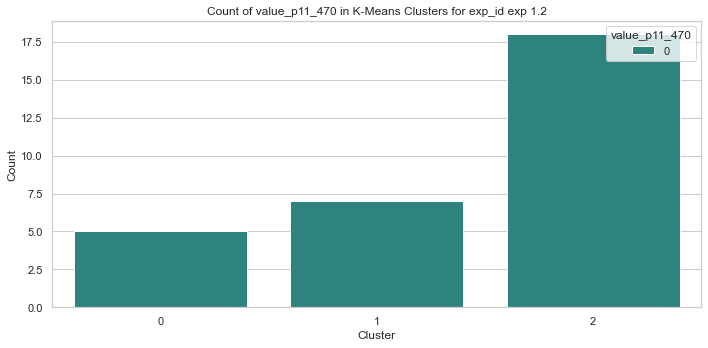

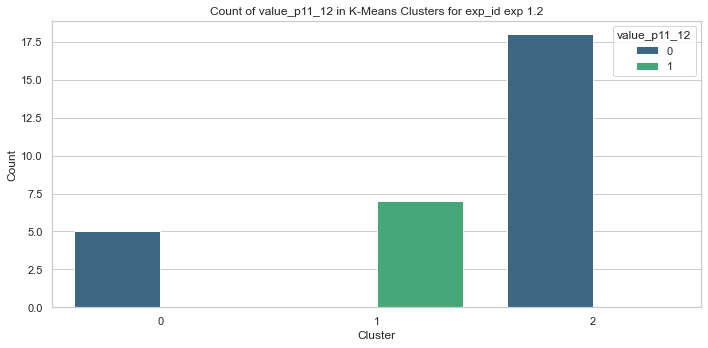

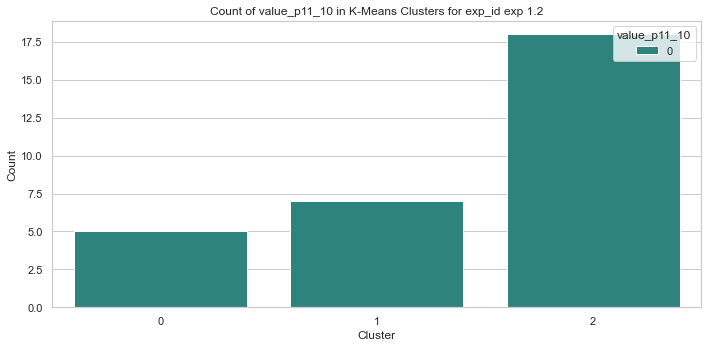

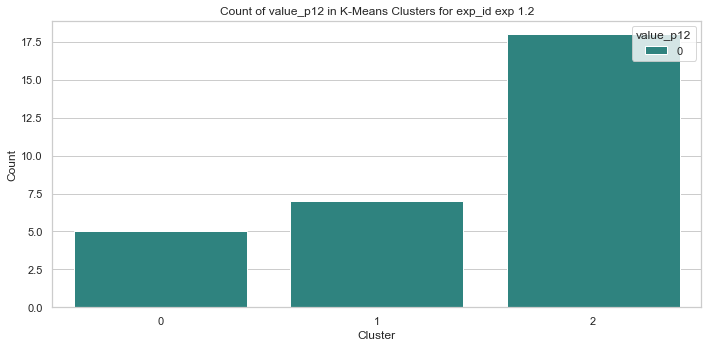

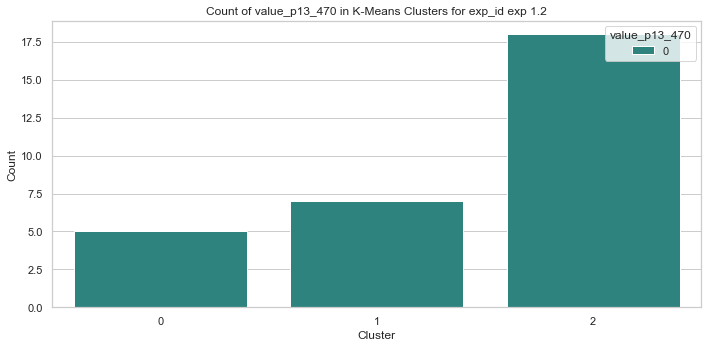

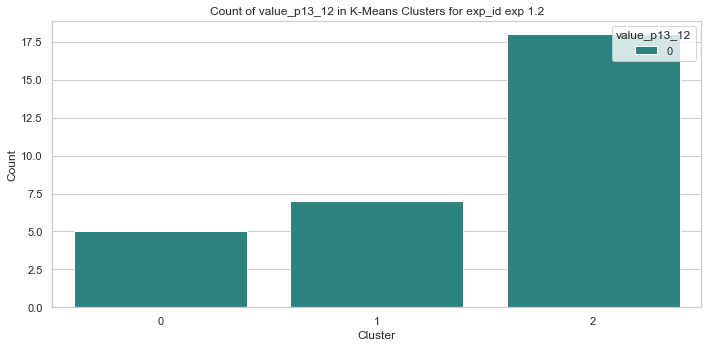

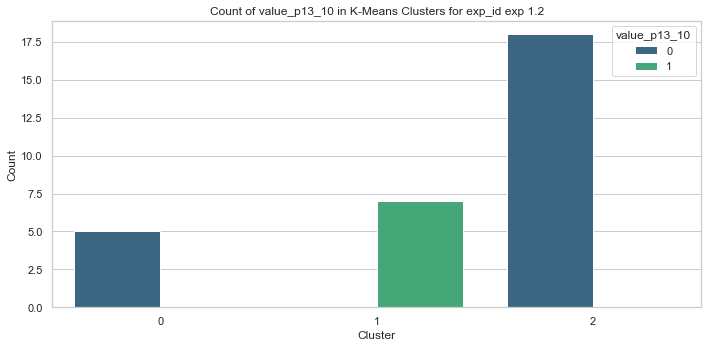

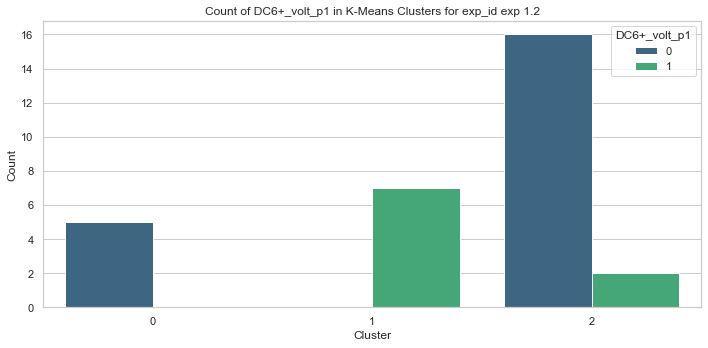

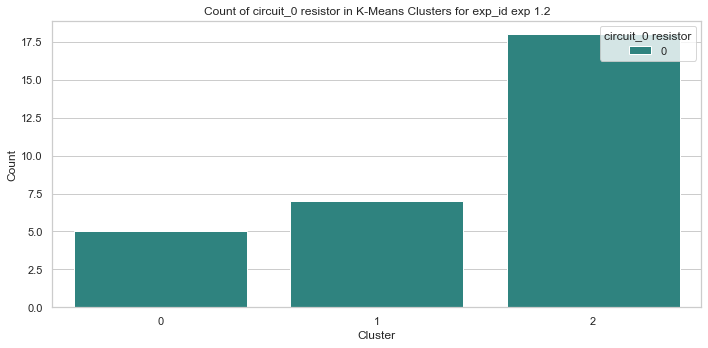

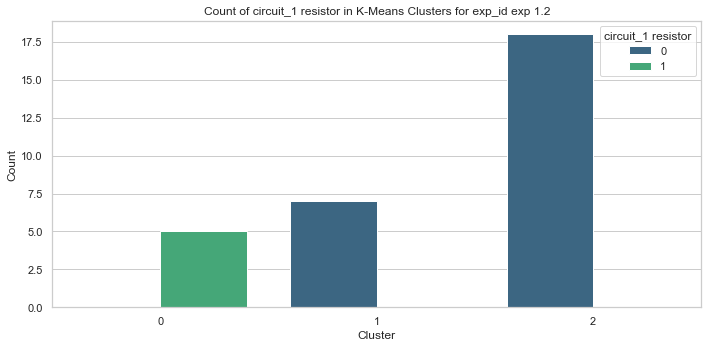

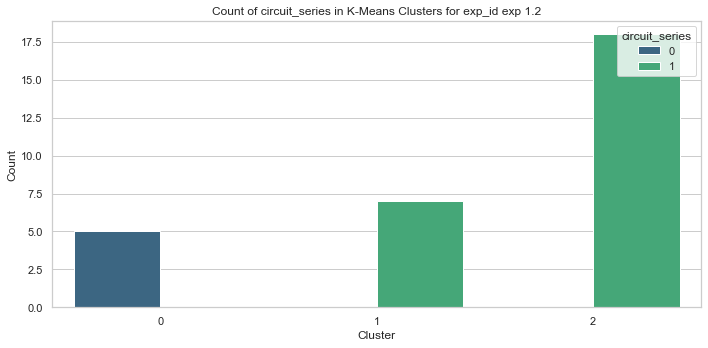

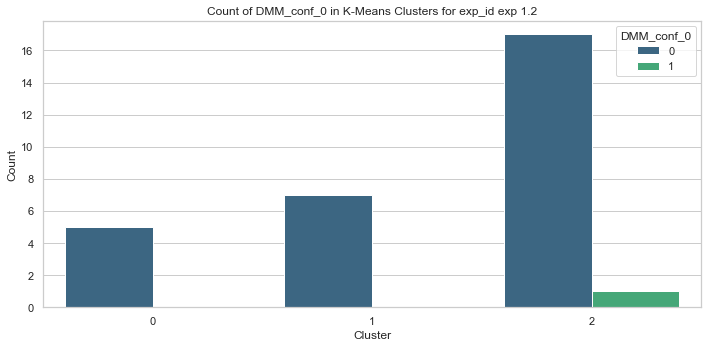

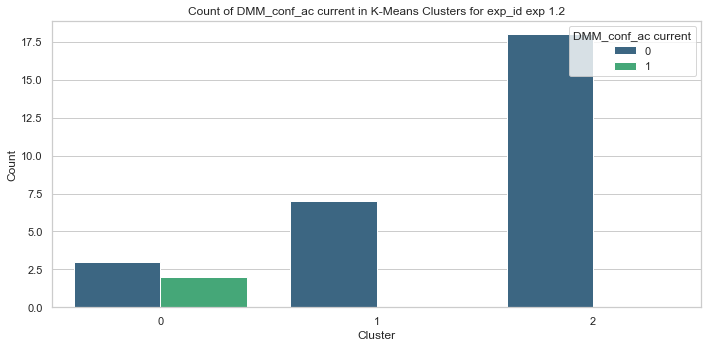

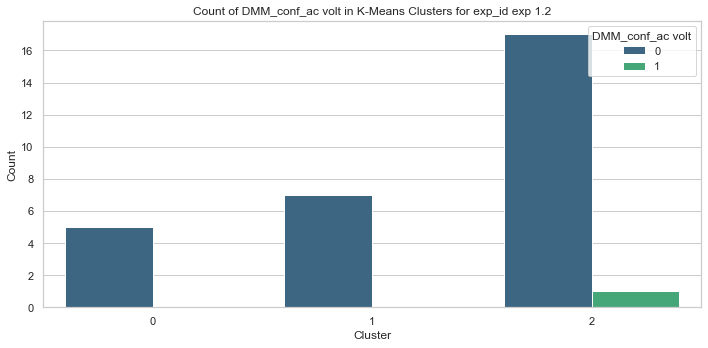

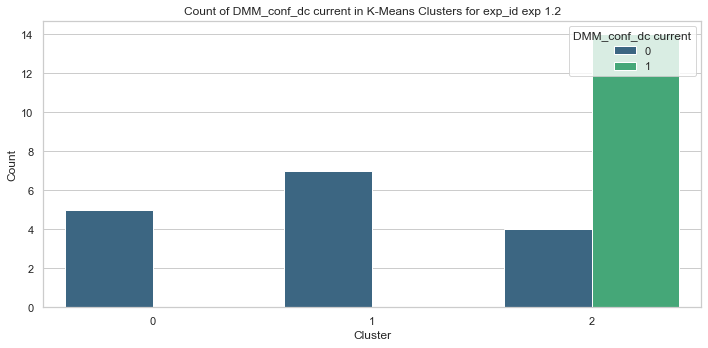

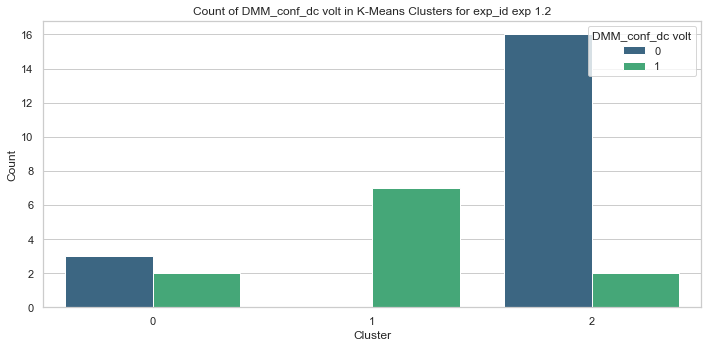

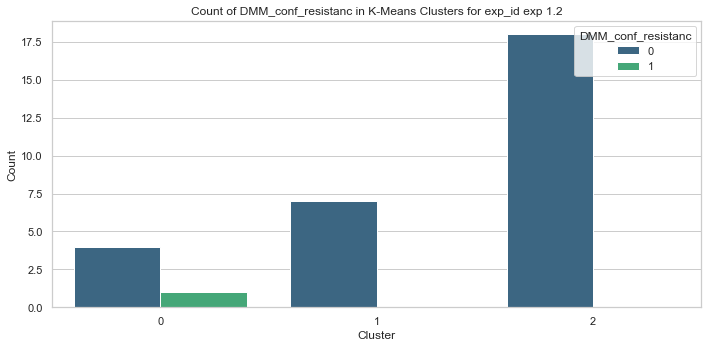

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn for better aesthetics
sns.set(style="whitegrid")

# Loop through each exp_id and each variable, and create a count plot for each
for exp_id in result_df['exp_id'].unique():
    exp_data = result_df[result_df['exp_id'] == exp_id]
    
    for variable in result_df.drop(['exp_id', 'cluster_k'], axis=1).columns:
        plt.figure(figsize=(10, 5))

        # Plot K-Means clusters
        sns.countplot(x='cluster_k', hue=variable, data=exp_data, palette='viridis', dodge=True)
        plt.title(f'Count of {variable} in K-Means Clusters for exp_id {exp_id}')
        plt.xlabel('Cluster')
        plt.ylabel('Count')
        plt.legend(title=variable, loc='upper right')

        plt.tight_layout()
        plt.show()
        


In [ ]:
#DOWNLOAD

import seaborn as sns
import os

# Set the style of seaborn for better aesthetics
sns.set(style="whitegrid")

# Create a directory to store the plots
output_dir = "kmeans_plots"
os.makedirs(output_dir, exist_ok=True)

# Loop through each exp_id and each variable, and create a count plot for each
for exp_id in result_df['exp_id'].unique():
    exp_data = result_df[result_df['exp_id'] == exp_id]
    
    for variable in result_df.drop(['exp_id', 'cluster_k'], axis=1).columns:
        plt.figure(figsize=(10, 5))

        # Plot K-Means clusters
        sns.countplot(x='cluster_k', hue=variable, data=exp_data, palette='viridis', dodge=True)
        plt.title(f'Count of {variable} in K-Means Clusters for exp_id {exp_id}')
        plt.xlabel('Cluster')
        plt.ylabel('Count')
        plt.legend(title=variable, loc='upper right')

        # Save the plot to a file
        output_file = os.path.join(output_dir, f"kmeans_plot_exp_{exp_id}_variable_{variable}.png")
        plt.savefig(output_file)
        plt.close()


## Visualização

In [ ]:
import hvplot.pandas
import hvplot.dask

pn.extension('tabulator')
pn.extension()

In [ ]:
AtivFinal = UserAtivFinal.iloc[:]
AtivFinal.drop(AtivFinal.columns[13:], axis=1, inplace=True)
AtivFinal.drop(AtivFinal.columns[2:3], axis=1, inplace=True)
AtivFinal['exp_id'] = UserAtivFinal['exp_id']
AtivFinal.reset_index(drop=True, inplace=True)

#dataframe pipeline interactive
idf = act_df.interactive()
last = AtivFinal.interactive()
#bkt = bkt_df.interactive()
freq = freq_df.interactive()
tct = tct_df.interactive()
acce = manip.interactive()
erro = class_error.interactive()

In [ ]:
#botao selecionar estudante
select_stud = pn.widgets.Select(
    options = ['Select'] + act_df['sessionkey'].value_counts().index.tolist(),
    name = 'Session')

#botao selecionar problema
select_exp_id = pn.widgets.Select(
    options = ['Select'] + act_df['exp_id'].value_counts().index.tolist(),
    name = 'Experiment')



#histograma execuções por sessão
exec_line_plot = idf[(idf['sessionkey']==select_stud) & (idf['exp_id'] ==   select_exp_id)].hvplot.bar(
                                             x='sessionkey',
                                             y='execution_count')

#histograma notas por sessão
attmp_line_plot = idf[(idf['sessionkey']==select_stud) & (idf['exp_id'] ==   select_exp_id)].hvplot.line(
                                             x='sessionkey',
                                             y='score')

#grafico em barra frequencia de circuitos
freq_source_bar_plot = freq[freq['exp_id']==  select_exp_id].hvplot.bar(
                                   x='Circuit',
                                   y='Frequency', height=300, width=1200)


#tabela de erro

def update_table(event):

    global filtered1_df

    selected_student = select_stud.value
    selected_problem = select_exp_id.value
    
    if selected_student == 'Select' or selected_problem == 'Select':
        empty_df = pd.DataFrame(columns=class_error.columns)
        error_table.object = empty_df
    else:
        filtered1_df = class_error[(class_error['Session'] == selected_student) & (class_error['Experiment'] == selected_problem)]
    
    error_table.object = filtered1_df
    
select_stud.param.watch(update_table, 'value')
select_exp_id.param.watch(update_table, 'value')

# Create an initial empty table
empty_df = pd.DataFrame(columns=df.columns)
error_table = pn.panel(empty_df)

In [ ]:
#frequencia dos tipos de erro
error_freq = class_error[:]

error_freq = error_freq.drop(columns=['Session'])

# Create a function to generate the bar plot
def generate_bar_plot(selected_column, error_freq):
    # Filter the DataFrame based on the selected problem classification
    filtered_erro = error_freq[error_freq['Experiment'] == selected_column]

    # Select only valid columns of numeric type before calling the reduction
    numeric_columns = filtered_erro.select_dtypes(include='number').columns
    frequencies = filtered_erro[numeric_columns].sum()

    # Create a bar plot
    bar_plot = frequencies.hvplot.bar(
        xlabel='Columns',
        ylabel='Frequency', height=300, width=1200
    )

    return bar_plot

# Function to update the bar plot based on the selected problem classification
@pn.depends(select_exp_id.param.value)
def update_bar_plot(selected_problem):
    return generate_bar_plot(selected_problem, error_freq)



In [ ]:
#matriz componente por aluno

# Define the heatmap function
def heatmap(selected_exp_id):
    # Filter data based on the selected exp_id
    selected_data = AtivFinal[AtivFinal['exp_id'] == selected_exp_id]

    # Create the heatmap using hvplot
    plot = selected_data.set_index('sessionkey').iloc[:, 1:-1].transpose().hvplot.heatmap(
        cmap='Blues', height=300, width=1200, colorbar=False
    ).opts(shared_axes=False)
    
    return plot

# Define the callback function for the widget
def update_heatmap(event):
    selected_exp_id = select_exp_id.value
    heatmap_plot.object = heatmap(selected_exp_id)

# Bind the callback function to the widget
select_exp_id.param.watch(update_heatmap, 'value')

# Initial heatmap plot
initial_exp_id =   select_exp_id.value
heatmap_plot = pn.panel(heatmap(initial_exp_id))

In [ ]:
#matriz de correlação

corr_df = act_dm[:]

# Function to generate the correlation matrix heatmap based on selected exp_id
@pn.depends(select_exp_id.param.value)
def correlation_heatmap(selected_exp_id):
    # Filter data based on the selected exp_id
    if selected_exp_id == 'Select':
        selected_data = corr_df
    else:
        selected_data = corr_df[corr_df['exp_id'] == selected_exp_id]

    # Calculate correlation matrix
    correlation_matrix = selected_data.corr()

    # Create heatmap using hvplot
    heatmap = correlation_matrix.hvplot.heatmap(cmap='Blues', width=1200, height=800)

    return heatmap


In [ ]:
session_indicator = pn.indicators.Number(name='Session', value=manip.loc[0, 'Session'])

# Callback function to update indicators based on exp_id selection
def update_session(event):
    selected_exp_id = event.new
    selected_row = manip[manip['exp_id'] == selected_exp_id].iloc[0]
    session_indicator.value = selected_row['Session']

# Bind callback function to exp_id selection
select_exp_id.param.watch(update_session, 'value')

In [ ]:
# Create Panel widgets
circ_uniq_indicator = pn.indicators.Number(name='circ_uniq', value=manip.loc[0, 'circ_uniq'])

# Callback function to update indicators based on exp_id selection
def update_circ(event):
    selected_exp_id = event.new
    selected_row = manip[manip['exp_id'] == selected_exp_id].iloc[0]
    circ_uniq_indicator.value = selected_row['circ_uniq']

# Bind callback function to exp_id selection
select_exp_id.param.watch(update_circ, 'value')

In [ ]:
#TCT

# Define a function to update the number indicator
def update_number(event):
    selected_problem = event.new
    selected_row = tct_df[tct_df['exp_id'] == selected_problem]
    number.name = 'Difficulty level: ' + selected_row['item_rating'].values[0]
    number.value = float(selected_row['average_score'])

# Create a selection widget
#problem_selector = pn.widgets.Select(options=grau_df['exp_id'].tolist())

# Bind the selection widget to the update_number function
select_exp_id.param.watch(update_number, 'value')

# Create the initial number indicator
number = pn.indicators.Number(
    name='Difficulty level: ' + str(tct_df['item_rating'][0]),
    value=float(tct_df['average_score'][0]),
    font_size="45pt", title_size="14pt",
    colors=[(0.5, 'red'), (0.6, 'gold'), (1.1, 'green')]
)

In [ ]:
#Clustering

# Function to generate the bar plot based on selected exp_id
@pn.depends(  select_exp_id.param.value)
def plot_cluster_sizes_k(selected_exp_id):
    # Filter data based on the selected exp_id
    if selected_exp_id == 'All':
        selected_data = cluster_sizes_k
    else:
        selected_data = cluster_sizes_k[cluster_sizes_k['exp_id'] == selected_exp_id]

    # Create bar plot using hvplot
    bar_plot = selected_data.hvplot.bar(
        x='cluster_k', y='cluster_sizes_k', stacked=True, 
        title=f'K-means Cluster Sizes per exp_id - Selected: {selected_exp_id}',
        xlabel='Cluster', ylabel='Cluster Size', width = 600, max_width = 800, height=500
    )

    return bar_plot

In [ ]:
import holoviews as hv
from holoviews import opts

cluster_result = result_df[:]

# Group by 'exp_id' and 'Cluster_k', then sum up the counts for each variable
result = cluster_result.groupby(['exp_id', 'cluster_k']).sum()

# Define a function to create a grouped bar plot using hvplot
def grouped_bar_plot(exp_id, variable):
    if exp_id == 'Select':
        return hv.Div('')
    else:
        values = result.loc[exp_id, variable].hvplot.bar(
            by='cluster_k',
            stacked=False,
            width=800,
            height=400,
            xlabel='exp_id',
            ylabel='Count',
            title=f'Counts of {variable} for exp_id {exp_id}',
            legend='top_right',
        )
        return values

select_var = pn.widgets.Select(
    options=['Select'] + cluster_result.columns[1:-1].tolist(),
    name='Variable'    
)

# Define a function to update the plot based on widget values
@pn.depends(select_exp_id.param.value, select_var.param.value)
def update_plot(exp_id, variable):
    new_plot = grouped_bar_plot(exp_id, variable)
    return new_plot



In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import panel as pn

# Create the dataframe
act_ap = UserAtivFinal[:]
act_ap = act_ap.drop(columns=['sessionkey', 'time_request', 'execution_count', 'DC6+_volt',
       'DC6+_cur', 'DC25+_volt', 'DC25+_cur', 'DC25-_volt', 'DC25-_cur', 'score', 'time_difference'])


# List of columns to convert to boolean type
columns_to_convert = ['R12K', 'R470K', 'R10K', 'DC+6V', 'DMM_v', 'DMM_mA', 'GND',
       'value_p11_470', 'value_p11_12', 'value_p11_10', 'value_p12',
       'value_p13_470', 'value_p13_12', 'value_p13_10', 'DC6+_volt_p1',
       'error_id', 'error_esp', 'circuit_0 resistor', 'circuit_1 resistor',
       'circuit_series', 'DMM_conf_0', 'DMM_conf_ac current',
       'DMM_conf_ac volt', 'DMM_conf_dc current', 'DMM_conf_dc volt',
       'DMM_conf_resistanc']

# Convert each column to boolean type
for col in columns_to_convert:
    act_ap[col] = act_ap[col].astype(bool)


# Define a function to generate rules for a specific ID
def generate_rules_for_id(id_value, act_ap):
    subset = act_ap[act_ap['exp_id'] == id_value]
    frequent_itemsets = apriori(subset[['R12K', 'R470K', 'R10K', 'DC+6V', 'DMM_v', 'DMM_mA', 'GND',
       'value_p11_470', 'value_p11_12', 'value_p11_10', 'value_p12',
       'value_p13_470', 'value_p13_12', 'value_p13_10', 'DC6+_volt_p1',
       'error_id', 'error_esp', 'circuit_0 resistor', 'circuit_1 resistor',
       'circuit_series', 'DMM_conf_0', 'DMM_conf_ac current',
       'DMM_conf_ac volt', 'DMM_conf_dc current', 'DMM_conf_dc volt',
       'DMM_conf_resistanc']], min_support=0.5, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
    return rules

# Create a Select widget for choosing the ID
id_selector = pn.widgets.Select(name='Select ID', options=list(act_ap['exp_id'].unique()))

# Define a function to display rules based on the selected ID
@pn.depends(id_selector.param.value)
def display_rules(id_value):
    rules = generate_rules_for_id(id_value, act_ap)
    return rules.head(10)

# Create a panel to display the Select widget and the rules
panel = pn.Column(id_selector, display_rules)
panel.servable()


In [ ]:
#-----DESCRIÇÃO DAS ATIVIDADES-----
activity_description = pn.panel('No activity selected', name='Activity Description')

def update_activity_description(event):
    
    selected_activity = event.new
    
    if selected_activity == 'exp 1.1':
        description = """
        Material: 1,2KΩ, 10KΩ or 470Ω resistors, multimeter e dc power.

        Objetive: measure the current trough one resistor and compare it with the expected results of Ohm's Law.
        """
    elif selected_activity == 'exp 1.2':
        description = """
         Material: 1,2KΩ, 10KΩ and 470Ω resistors, multimeter e dc power.

        Objetive: measure the current at the circuit and, using the Ohm's Law, and calculate the equivalent resistance of the circuit. """
    elif selected_activity == 'exp 1.3':
        description = """
         Material: 1,2KΩ, 10KΩ and 470Ω resistors, multimeter e dc power.

        Objetive:  measure the voltage at each resistor, to understand how the voltage is “distributed” between the resistors.

        """
    else:
        description = 'No activity selected'
    
    activity_description.object = description

# Bind the callback function to the select widget's parameter 'value'
select_exp_id.param.watch(update_activity_description, 'value')

In [ ]:
#-----DESCRIÇÃO DAS COMPETENCIAS-----
kc_description = pn.panel('No activity selected', name='Competence Description')

def update_activity_description(event):
    selected_kc = event.new
   
    if selected_kc == 'exp 1.1':
        description = """
              •  Properly select and operate the components.
              • Connect components.
              • Build the circuit in a clear structure.
              • Connect the DC power +6V. 
              • Choose the right voltage. 
              • Connect the multimeter 
              • Place the  measurement leads to mA 
              • Place the value of the  measurement spinner in A
              • Measure the current
        """
    elif selected_kc == 'exp 1.2':
        description = """
               •  Properly select and operate the components.
               • Connect components.
               • Build the circuit in a clear structure.
               • Connect the DC power +6V. 
               • Choose the right voltage. 
               • Connect the multimeter 
               • Place the  measurement leads to mA 
               • Place the value of the  measurement spinner in A
               • Measure the current
         """
    elif selected_kc == 'exp 1.3':
        description = """
               •  Properly select and operate the components.
               • Connect components.
               • Build the circuit in a clear structure.
               • Connect the DC power +6V. 
               • Choose the right voltage. 
               • Connect the multimeter 
               • Place the  measurement leads to V 
               • Place the value of the  measurement spinner in V
               • Measure the voltage
        """
    else:
        description = 'No activity selected'
    
    kc_description.object = description

# Bind the callback function to the select widget's parameter 'value'
select_exp_id.param.watch(update_activity_description, 'value')

In [ ]:
from panel.template import FastListTemplate

pn.extension()

# Define pages as classes
class Page1:
    def __init__(self):
        self.content = pn.Column(
        #pn.Row('##Informações Gerais da Atividade', margin=(0, 500), sizing_mode="stretch_width"),
        pn.Row(
            pn.Column('# Activity Description', pn.layout.Divider(), activity_description, styles=dict(background='whitesmoke'), sizing_mode="stretch_width"),
            pn.Column(session_indicator),
        ),
        pn.Row(
            pn.Column('## Execution per Session', pn.widgets.TooltipIcon(value="This chart represents the "),exec_line_plot.panel(width_policy='min'), sizing_mode="stretch_width"),
            pn.Column('## Score by attemps', pn.widgets.TooltipIcon(value="This chart represents the "), attmp_line_plot.panel(width_policy='max'), sizing_mode="stretch_width")
        ),
        pn.Row(
            pn.Column('## Error Classification', pn.widgets.TooltipIcon(value="This table represents the "), error_table, sizing_mode="stretch_width")
        ),
    )

    def view(self):
        return self.content

    
class Page2:
    def __init__(self):
        self.content = pn.Column(
            pn.Row(
                pn.Column('## Most Frequent Circuit', pn.widgets.TooltipIcon(value="This table represents the "), sizing_mode="stretch_width"),
                pn.Column(circ_uniq_indicator),
            ),
            pn.Row(
                freq_source_bar_plot.panel(width_policy='max'), sizing_mode="stretch_width",
            ),
            pn.Row(
               "## Erros's frequency according to each error classification ", pn.widgets.TooltipIcon(value="This table represents the ")
            ),
            pn.Row(
               update_bar_plot, sizing_mode="stretch_width",
            ),
            pn.Row(
                "## Componets used per student ", pn.widgets.TooltipIcon(value="This table represents the ")
            ),
            pn.Row(
                heatmap_plot, sizing_mode="stretch_width"
            ),

            
    )

    def view(self):
        return self.content
    
    
class Page3:
    def __init__(self):
        self.content = pn.Column(
        pn.Row(
            pn.Column('# Competencies Description', pn.layout.Divider(), kc_description, styles=dict(background='whitesmoke'), sizing_mode="stretch_width"),
            pn.Column(number),
        ),
        #pn.Row(
        #        "## Learn Probability ", pn.widgets.TooltipIcon(value="This table represents the ")
        #),
       # pn.Row(
        #    pn.Column(bkt_source, bkt_source_bar_plot.panel(width_policy='max')),
        #),
        pn.Row(
            "## K-meas ", pn.widgets.TooltipIcon(value="This table represents the ")
        ),
        pn.Row(
            #pn.Column(number.clone(value=grau_df['Difficulty_Score'][0]), sizing_mode="stretch_width"),
            pn.Column(plot_cluster_sizes_k),
        ),
        pn.Row(
            "## Clustering per component ", pn.widgets.TooltipIcon(value="This table represents the ")
        ),
        pn.Row(
                select_var,
                #update_plot
        ),
        pn.Row(
            "## Correlation ", pn.widgets.TooltipIcon(value="This table represents the ")
        ),
        pn.Row(
            correlation_heatmap, sizing_mode="stretch_width"
        ),
        pn.Row(
            "## Association Rules ", pn.widgets.TooltipIcon(value="This table represents the ")
        ),
        pn.Row(
            display_rules
        )

    )

    def view(self):
        return self.content

# Instantiate pages and add them to the pages dictionary
pages = {
    "Page 1": Page1(),
    "Page 2": Page2(),
    "Page 3": Page3(),
}


# Function to show the selected page
def show_page(page_instance):
    main_area.clear()
    main_area.append(page_instance.view())

# Define buttons to navigate between pages
page1_button = pn.widgets.Button(name="General Information", button_type="light", sizing_mode="stretch_width")
page2_button = pn.widgets.Button(name="Group Information", button_type="light", sizing_mode="stretch_width")
page3_button = pn.widgets.Button(name="Competencies Information", button_type="light", sizing_mode="stretch_width")

# Set up button click callbacks
page1_button.on_click(lambda event: show_page(pages["Page 1"]))
page2_button.on_click(lambda event: show_page(pages["Page 2"]))
page3_button.on_click(lambda event: show_page(pages["Page 3"]))


# Create the sidebar
sidebar = pn.Column(  select_exp_id, select_stud)

# Create the main area and display the first page
main_area = pn.Column(pages["Page 1"].view())

# Create the Material Template and set the sidebar and main area
template = FastListTemplate(
    title="LEDA",
    header=[page1_button, page2_button, page3_button],
    sidebar=[sidebar],
    main=[main_area],
)


# Serve the Panel app
template.show()

In [ ]:
import pandas as pd
import panel as pn
import hvplot.pandas

# Defining the data
data = {
    'execution_count': [1, 2, 1, 2, 3],
    'sessionkey': ['session 1', 'session 1', 'session 2', 'session 2', 'session 2'],
    'exp_id': ['exp 0', 'exp 1.1', 'exp 1.1', 'exp 1.2', 'exp 1.2'],
    'score': [0.75, 0.88, 0.60, 0.60, 0.30],
    'error_id': ['error 1.1', 'error 1.4', 'error 1.7', 'error 1.1', 'error 1.4'],
    'error_esp': ['error 1.1.1', 'error 1.4.3', 'error 1.7.1', 'error 1.1.3', 'error 1.4.2']
}

# Creating a DataFrame from the data
df = pd.DataFrame(data)

#histograma execuções por sessão
def exec_line_plot(exp_id, error_id, error_esp):
    filtered_data = act_df[(act_df['exp_id'] == exp_id) & (act_df['error_id'] == error_id) & (act_df['error_esp'] == error_esp)]
    return filtered_data.hvplot.bar(x='sessionkey', y='execution_count', title=f'Execution count for {exp_id} with error {error_id} and error esp {error_esp}')


#histograma notas por sessão
def score_line_plot(exp_id, error_id, error_esp):
    filtered_data = act_df[(act_df['exp_id'] == exp_id) & (act_df['error_id'] == error_id) & (act_df['error_esp'] == error_esp)]
    return filtered_data.hvplot.bar(x='sessionkey', y='score', title=f'Scores for {exp_id} with error {error_id} and error esp {error_esp}')


# Getting unique values for dropdowns
exp_ids = act_df['exp_id'].unique().tolist()
error_ids = act_df['error_id'].unique().tolist()
error_esps = act_df['error_esp'].unique().tolist()

# Create interactive widgets with Panel
exp_input = pn.widgets.Select(name='Experiment ID:', options=exp_ids)
error_id_dropdown = pn.widgets.Select(name='Error ID:', options=error_ids)
error_esp_dropdown = pn.widgets.Select(name='Error ESP:', options=error_esps)

# Define the panel
@pn.depends(exp_input.param.value, error_id_dropdown.param.value, error_esp_dropdown.param.value)
def exec_plot(exp_id, error_id, error_esp):
    return exec_line_plot(exp_id, error_id, error_esp)

@pn.depends(exp_input.param.value, error_id_dropdown.param.value, error_esp_dropdown.param.value)
def score_plot(exp_id, error_id, error_esp):
    return score_line_plot(exp_id, error_id, error_esp)



panel = pn.Column(
    pn.Row(exp_input, error_id_dropdown, error_esp_dropdown),
    exec_plot,
    score_plot
)

# Show the panel
panel.servable()
